# N:2 MENT — sample-based solver

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.sim import simulate
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj2D_Contour
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Source distribution

In [3]:
dist_name = "gaussian_mixture"
ndim = 6
xmax = 3.5
seed = 12345

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

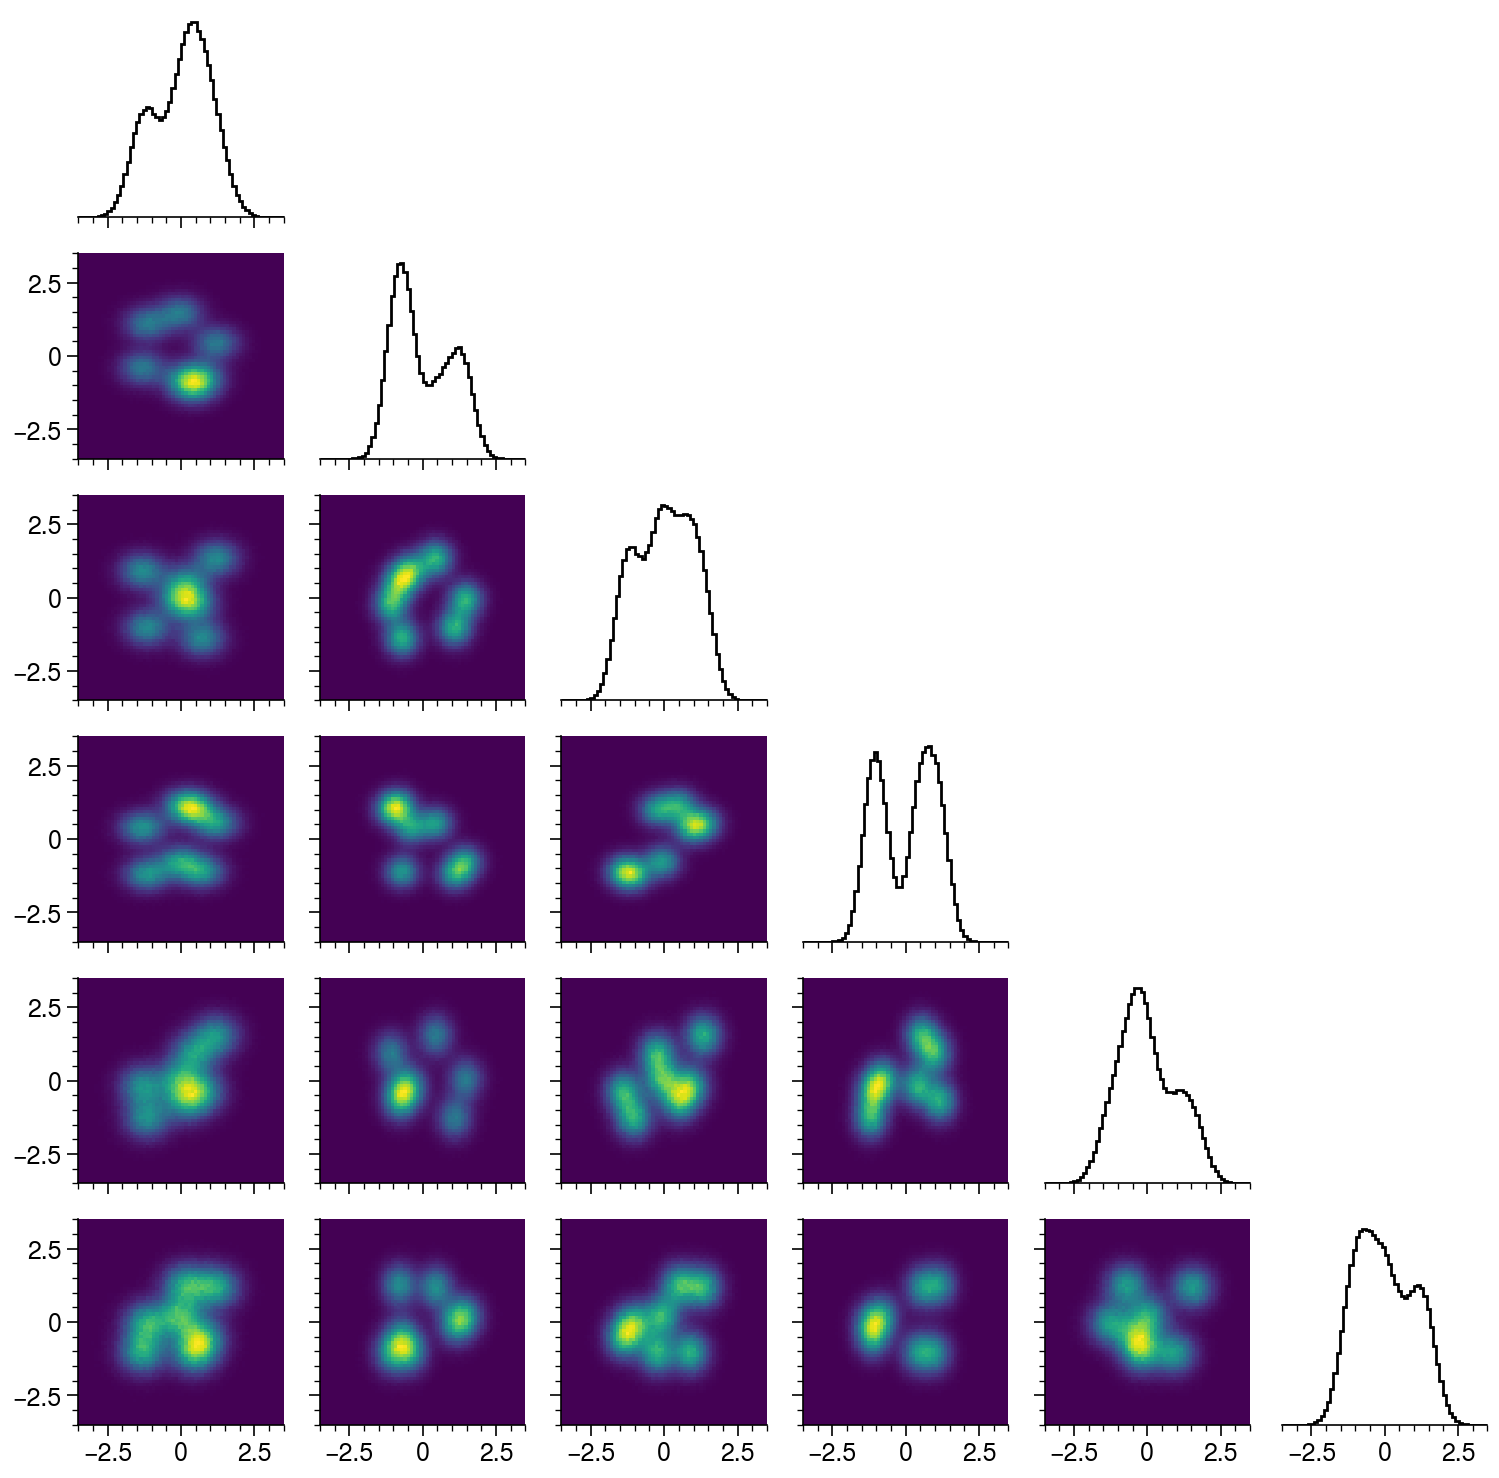

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
nmeas = ndim * (ndim - 1) // 2
nbins = 64
blur = 0.0
kde = False
kde_bandwidth_frac = 1.0
axis_meas = (0, 2)

In [7]:
# Create transforms (permutation matrices)
transfer_matrices = []
for i in range(ndim):
    for j in range(i):
        matrices = []
        for k, l in zip(axis_meas, (j, i)):
            matrix = np.identity(ndim)
            matrix[k, k] = matrix[l, l] = 0.0
            matrix[k, l] = matrix[l, k] = 1.0
            matrices.append(matrix)
        transfer_matrices.append(np.linalg.multi_dot(matrices[::-1]))

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

# Create histogram diagnostics
axis_proj = axis_meas
bin_edges = 2 * [np.linspace(-xmax, xmax, nbins + 1)]

projections = []
for transform in transforms:
    projection = ment.diag.HistogramND(
        axis=axis_meas,
        edges=bin_edges,
        kde=kde,
        kde_bandwidth_frac=kde_bandwidth_frac,
        blur=blur,
        thresh=0.0,
        thresh_type="abs",
    )
    projections.append([projection])

# Generate data
projections = ment.sim.simulate_with_diag_update(
    x_true,
    transforms,
    projections,
    kde=False,
    blur=False,
    thresh=5.00e-03,
)

In [8]:
# @interact(index=(0, nmeas - 1))
# def update(index: int):
#     coords = unravel(projections)[index].coords
#     values = unravel(projections)[index].values

#     fig, ax = plt.subplots()
#     ax.pcolormesh(coords[0], coords[1], values.T, colorbar=True,)

## Model

In [9]:
sampler = "mcmc"
nsamp = 1_000_000
burnin = 500
chains = 1000
c = 2.4 / np.sqrt(ndim)

if sampler == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif sampler == "mcmc":
    proposal_cov = 0.1 * np.eye(ndim)

    start = np.random.multivariate_normal(np.zeros(ndim), 0.5 * np.eye(ndim), size=chains)

    sampler = ment.samp.MetropolisHastingsSampler(
        ndim=ndim,
        chains=chains,
        proposal_cov=proposal_cov,
        start=start,
        burnin=burnin,
        shuffle=True,
        verbose=True,
    )
else:
    raise ValueError

In [10]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=nsamp,
    mode="sample",
    verbose=True,
)

## Training

In [11]:
plot_nsamp = 1_000_000

In [12]:
def plot_model(model):
    figs = []

    # Sample particles
    x_pred = model.sample(plot_nsamp)

    # Plot reconstructed vs. true distribution
    grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25), diag_shrink=0.80)
    grid.plot_points(
        x_pred,
        limits=limits,
        bins=65,
        mask=False,
        cmap="viridis",
    )
    figs.append(grid.fig)

    # Simulate measurements
    projections_true = ment.sim.copy_histograms(model.projections)
    projections_pred = ment.sim.copy_histograms(model.diagnostics)
    projections_pred = ment.sim.simulate_with_diag_update(
        x_pred, transforms, projections_pred, kde=False, blur=False
    )

    projections_true = unravel(projections_true)
    projections_pred = unravel(projections_pred)

    # Plot simulated vs. measured projections.
    contour_levels = np.linspace(0.01, 1.0, 7)
    contour_colors = ["black", "red"]
    plot_kws = dict(
        process_kws=dict(blur=1.0, scale="max"),
        kind="contour",
        levels=contour_levels,
        lw=0.9,
    )

    ncols = min(nmeas, 7)
    nrows = int(np.ceil(nmeas / ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figwidth=(1.1 * ncols))
    for proj_true, proj_pred, ax in zip(projections_true, projections_pred, axs):
        psv.plot_hist(proj_true, ax=ax, colors=contour_colors[0], **plot_kws)
        psv.plot_hist(proj_pred, ax=ax, colors=contour_colors[1], **plot_kws)
    figs.append(fig)

    return figs

non numeric history values being saved


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 633.06it/s]

  9%|████████████▉                                                                                                                                        | 130/1499 [00:00<00:02, 645.14it/s]

 13%|███████████████████▍                                                                                                                                 | 196/1499 [00:00<00:02, 649.21it/s]

 18%|██████████████████████████▏                                                                                                                          | 263/1499 [00:00<00:01, 653.97it/s]

 22%|████████████████████████████████▊                                                                                                                    | 330/1499 [00:00<00:01, 656.91it/s]

 26%|███████████████████████████████████████▎                                                                                                             | 396/1499 [00:00<00:01, 655.68it/s]

 31%|██████████████████████████████████████████████                                                                                                       | 464/1499 [00:00<00:01, 660.33it/s]

 35%|████████████████████████████████████████████████████▉                                                                                                | 532/1499 [00:00<00:01, 663.66it/s]

 40%|███████████████████████████████████████████████████████████▌                                                                                         | 599/1499 [00:00<00:01, 660.34it/s]

 44%|██████████████████████████████████████████████████████████████████▏                                                                                  | 666/1499 [00:01<00:01, 655.54it/s]

 49%|████████████████████████████████████████████████████████████████████████▊                                                                            | 732/1499 [00:01<00:01, 652.91it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                     | 798/1499 [00:01<00:01, 652.60it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▉                                                               | 864/1499 [00:01<00:00, 649.27it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 929/1499 [00:01<00:00, 648.83it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 996/1499 [00:01<00:00, 652.55it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1062/1499 [00:01<00:00, 653.11it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1129/1499 [00:01<00:00, 657.30it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1196/1499 [00:01<00:00, 661.06it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1263/1499 [00:01<00:00, 660.45it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1330/1499 [00:02<00:00, 658.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1397/1499 [00:02<00:00, 661.64it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1464/1499 [00:02<00:00, 656.49it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 654.99it/s]

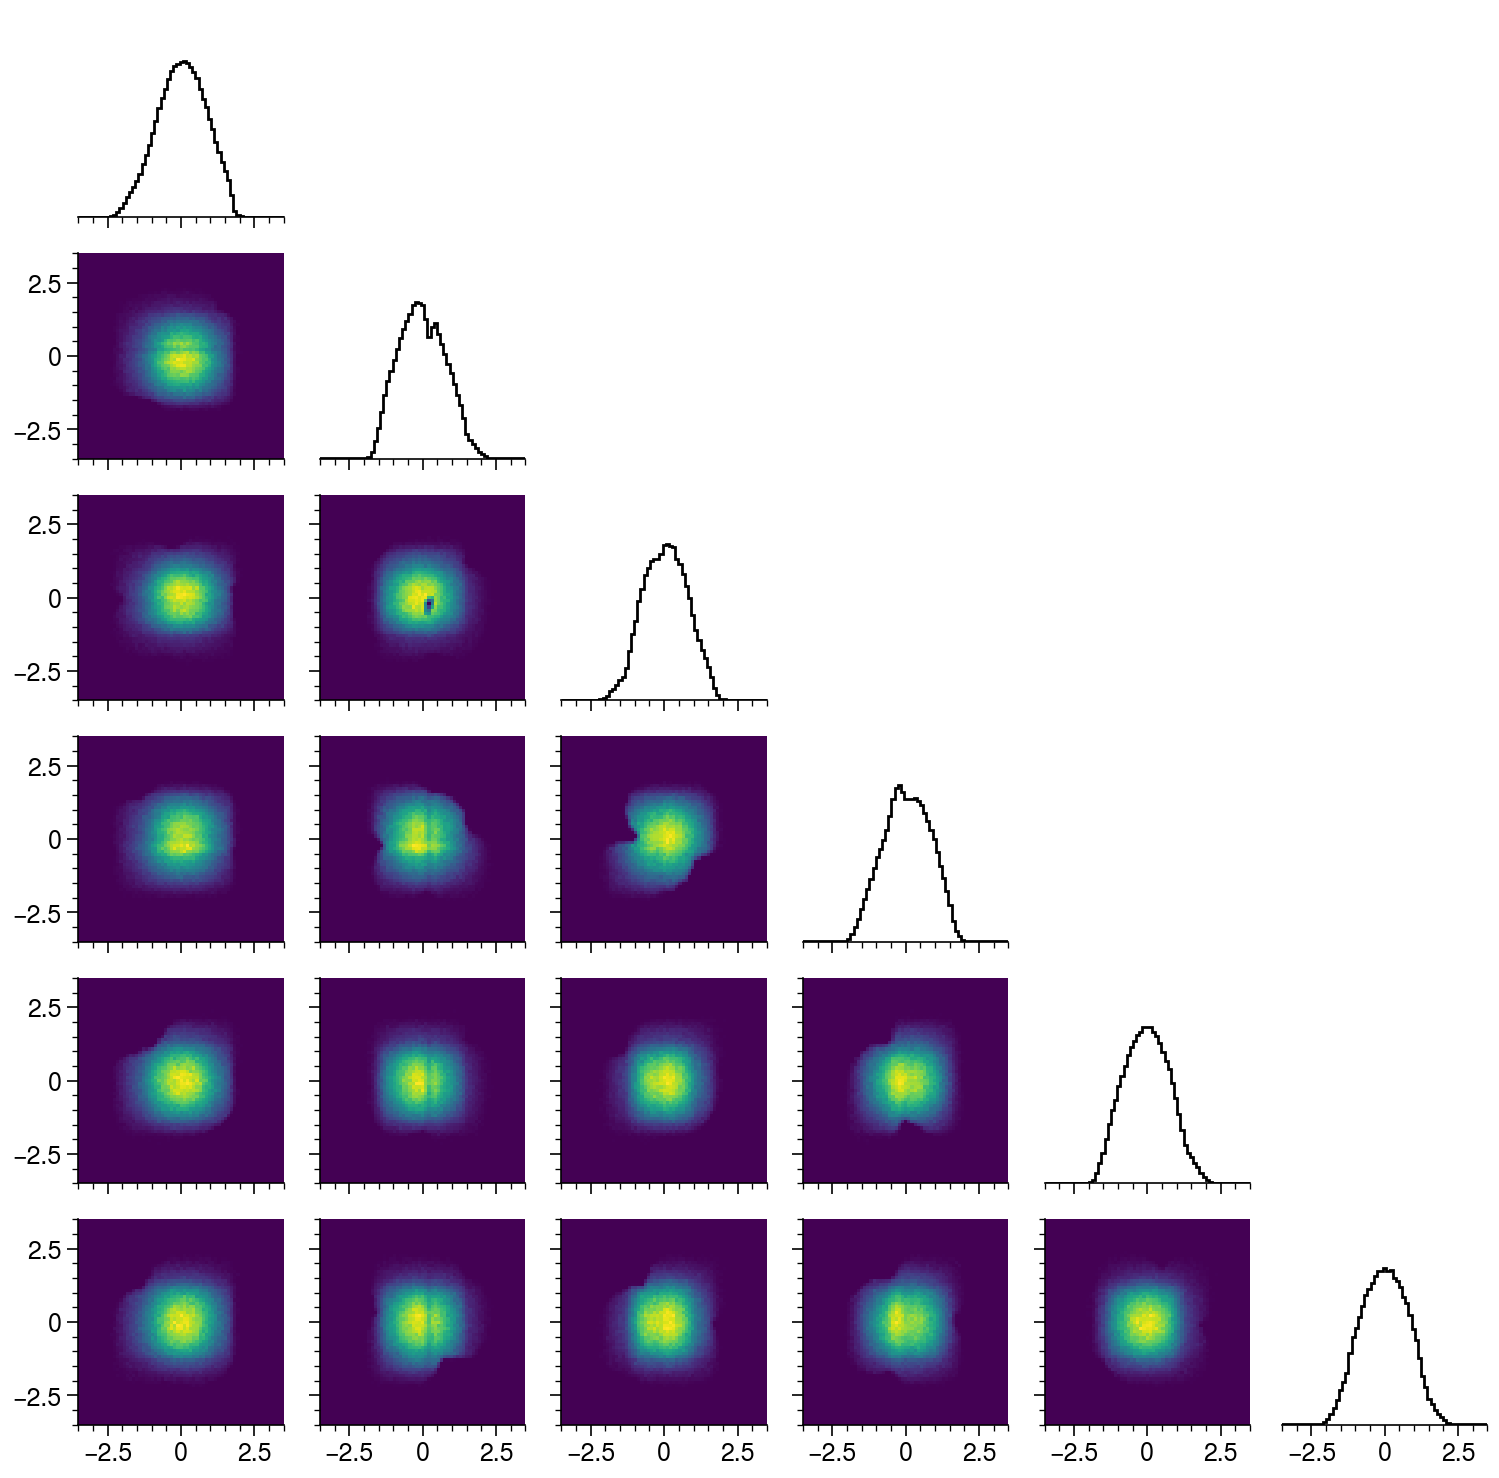

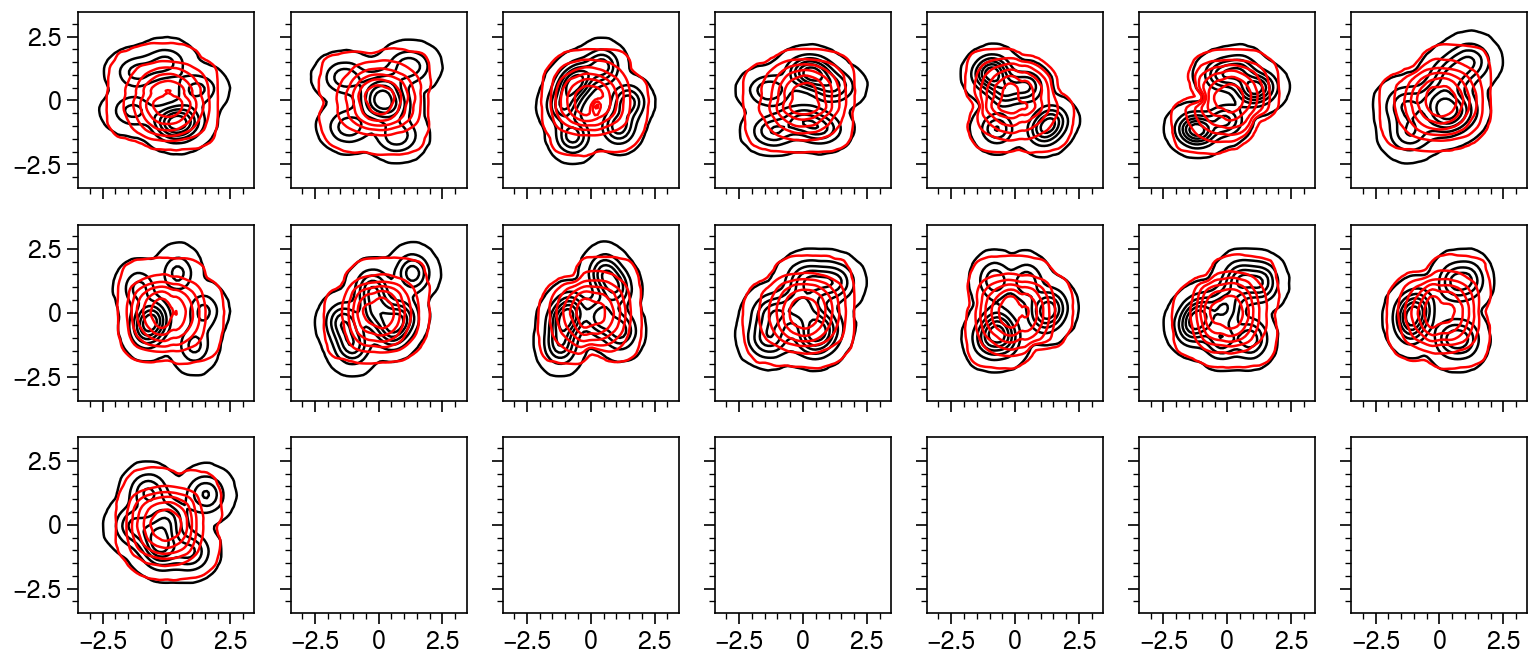

None
epoch = 1
transform=0
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                               | 65/1499 [00:00<00:02, 649.62it/s]

  9%|█████████████                                                                                                                                        | 131/1499 [00:00<00:02, 654.33it/s]

 13%|███████████████████▋                                                                                                                                 | 198/1499 [00:00<00:01, 656.85it/s]

 18%|██████████████████████████▎                                                                                                                          | 265/1499 [00:00<00:01, 659.66it/s]

 22%|█████████████████████████████████                                                                                                                    | 332/1499 [00:00<00:01, 662.91it/s]

 27%|███████████████████████████████████████▋                                                                                                             | 399/1499 [00:00<00:01, 651.79it/s]

 31%|██████████████████████████████████████████████▎                                                                                                      | 466/1499 [00:00<00:01, 657.55it/s]

 35%|████████████████████████████████████████████████████▉                                                                                                | 532/1499 [00:00<00:01, 652.64it/s]

 40%|███████████████████████████████████████████████████████████▍                                                                                         | 598/1499 [00:00<00:01, 649.11it/s]

 44%|██████████████████████████████████████████████████████████████████                                                                                   | 664/1499 [00:01<00:01, 651.18it/s]

 49%|████████████████████████████████████████████████████████████████████████▌                                                                            | 730/1499 [00:01<00:01, 647.81it/s]

 53%|███████████████████████████████████████████████████████████████████████████████                                                                      | 796/1499 [00:01<00:01, 649.12it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                               | 861/1499 [00:01<00:00, 647.78it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 927/1499 [00:01<00:00, 648.27it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 992/1499 [00:01<00:00, 648.35it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1057/1499 [00:01<00:00, 647.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1122/1499 [00:01<00:00, 643.67it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1187/1499 [00:01<00:00, 638.68it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1251/1499 [00:01<00:00, 634.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1316/1499 [00:02<00:00, 638.71it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1380/1499 [00:02<00:00, 635.31it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1445/1499 [00:02<00:00, 639.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 647.59it/s]

transform=1
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                               | 63/1499 [00:00<00:02, 625.21it/s]

  8%|████████████▌                                                                                                                                        | 126/1499 [00:00<00:02, 627.77it/s]

 13%|███████████████████                                                                                                                                  | 192/1499 [00:00<00:02, 642.07it/s]

 17%|█████████████████████████▌                                                                                                                           | 257/1499 [00:00<00:01, 636.55it/s]

 22%|████████████████████████████████                                                                                                                     | 323/1499 [00:00<00:01, 642.35it/s]

 26%|██████████████████████████████████████▋                                                                                                              | 389/1499 [00:00<00:01, 646.35it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 454/1499 [00:00<00:01, 639.67it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                 | 518/1499 [00:00<00:01, 639.34it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                           | 583/1499 [00:00<00:01, 640.51it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                    | 650/1499 [00:01<00:01, 647.83it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                              | 715/1499 [00:01<00:01, 641.97it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▌                                                                       | 780/1499 [00:01<00:01, 641.42it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                 | 846/1499 [00:01<00:01, 646.06it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 913/1499 [00:01<00:00, 649.67it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 978/1499 [00:01<00:00, 636.44it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1042/1499 [00:01<00:00, 634.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1107/1499 [00:01<00:00, 638.33it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1173/1499 [00:01<00:00, 642.42it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1239/1499 [00:01<00:00, 645.39it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1304/1499 [00:02<00:00, 641.19it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1369/1499 [00:02<00:00, 636.78it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1433/1499 [00:02<00:00, 636.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1497/1499 [00:02<00:00, 636.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 639.83it/s]

transform=2
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                               | 65/1499 [00:00<00:02, 644.63it/s]

  9%|████████████▉                                                                                                                                        | 130/1499 [00:00<00:02, 635.73it/s]

 13%|███████████████████▍                                                                                                                                 | 195/1499 [00:00<00:02, 641.77it/s]

 17%|█████████████████████████▉                                                                                                                           | 261/1499 [00:00<00:01, 646.16it/s]

 22%|████████████████████████████████▍                                                                                                                    | 326/1499 [00:00<00:01, 641.82it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 391/1499 [00:00<00:01, 640.34it/s]

 30%|█████████████████████████████████████████████▍                                                                                                       | 457/1499 [00:00<00:01, 646.34it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                 | 522/1499 [00:00<00:01, 637.52it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                          | 586/1499 [00:00<00:01, 635.56it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                    | 650/1499 [00:01<00:01, 636.63it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 717/1499 [00:01<00:01, 644.06it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                       | 783/1499 [00:01<00:01, 647.90it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                                | 848/1499 [00:01<00:01, 644.67it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 914/1499 [00:01<00:00, 649.08it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 980/1499 [00:01<00:00, 652.18it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1046/1499 [00:01<00:00, 654.00it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1113/1499 [00:01<00:00, 657.37it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1180/1499 [00:01<00:00, 658.06it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1247/1499 [00:01<00:00, 659.18it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1314/1499 [00:02<00:00, 659.96it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1381/1499 [00:02<00:00, 660.30it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1448/1499 [00:02<00:00, 662.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 650.80it/s]

transform=3
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                               | 66/1499 [00:00<00:02, 652.01it/s]

  9%|█████████████                                                                                                                                        | 132/1499 [00:00<00:02, 652.76it/s]

 13%|███████████████████▋                                                                                                                                 | 198/1499 [00:00<00:01, 655.69it/s]

 18%|██████████████████████████▎                                                                                                                          | 265/1499 [00:00<00:01, 657.28it/s]

 22%|█████████████████████████████████                                                                                                                    | 332/1499 [00:00<00:01, 659.22it/s]

 27%|███████████████████████████████████████▋                                                                                                             | 399/1499 [00:00<00:01, 660.71it/s]

 31%|██████████████████████████████████████████████▎                                                                                                      | 466/1499 [00:00<00:01, 655.41it/s]

 36%|████████████████████████████████████████████████████▉                                                                                                | 533/1499 [00:00<00:01, 657.66it/s]

 40%|███████████████████████████████████████████████████████████▋                                                                                         | 600/1499 [00:00<00:01, 658.55it/s]

 44%|██████████████████████████████████████████████████████████████████▎                                                                                  | 667/1499 [00:01<00:01, 660.64it/s]

 49%|████████████████████████████████████████████████████████████████████████▉                                                                            | 734/1499 [00:01<00:01, 662.65it/s]

 53%|███████████████████████████████████████████████████████████████████████████████▌                                                                     | 801/1499 [00:01<00:01, 661.38it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                              | 868/1499 [00:01<00:00, 663.44it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 935/1499 [00:01<00:00, 662.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1002/1499 [00:01<00:00, 663.18it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1069/1499 [00:01<00:00, 662.68it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1136/1499 [00:01<00:00, 663.07it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1203/1499 [00:01<00:00, 664.87it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1270/1499 [00:01<00:00, 665.93it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1337/1499 [00:02<00:00, 666.72it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1404/1499 [00:02<00:00, 667.67it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1471/1499 [00:02<00:00, 668.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 662.43it/s]

transform=4
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 637.91it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 636.48it/s]

 13%|███████████████████▎                                                                                                                                 | 194/1499 [00:00<00:02, 642.82it/s]

 17%|█████████████████████████▊                                                                                                                           | 260/1499 [00:00<00:01, 646.96it/s]

 22%|████████████████████████████████▍                                                                                                                    | 326/1499 [00:00<00:01, 650.59it/s]

 26%|██████████████████████████████████████▉                                                                                                              | 392/1499 [00:00<00:01, 653.01it/s]

 31%|█████████████████████████████████████████████▌                                                                                                       | 458/1499 [00:00<00:01, 633.85it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                 | 522/1499 [00:00<00:01, 628.23it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                          | 585/1499 [00:00<00:01, 628.15it/s]

 43%|████████████████████████████████████████████████████████████████▍                                                                                    | 648/1499 [00:01<00:01, 622.99it/s]

 47%|██████████████████████████████████████████████████████████████████████▋                                                                              | 711/1499 [00:01<00:01, 623.56it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 776/1499 [00:01<00:01, 629.50it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                 | 843/1499 [00:01<00:01, 639.49it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 909/1499 [00:01<00:00, 642.91it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 976/1499 [00:01<00:00, 649.40it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1043/1499 [00:01<00:00, 653.05it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1109/1499 [00:01<00:00, 650.52it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1175/1499 [00:01<00:00, 652.33it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1242/1499 [00:01<00:00, 656.16it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1308/1499 [00:02<00:00, 649.29it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1373/1499 [00:02<00:00, 647.69it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1440/1499 [00:02<00:00, 652.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 643.26it/s]

transform=5
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████                                                                                                                                                | 61/1499 [00:00<00:02, 608.63it/s]

  8%|████████████▎                                                                                                                                        | 124/1499 [00:00<00:02, 617.89it/s]

 12%|██████████████████▍                                                                                                                                  | 186/1499 [00:00<00:02, 609.82it/s]

 16%|████████████████████████▌                                                                                                                            | 247/1499 [00:00<00:02, 602.83it/s]

 21%|██████████████████████████████▌                                                                                                                      | 308/1499 [00:00<00:01, 599.96it/s]

 25%|████████████████████████████████████▋                                                                                                                | 369/1499 [00:00<00:01, 602.68it/s]

 29%|██████████████████████████████████████████▋                                                                                                          | 430/1499 [00:00<00:01, 600.84it/s]

 33%|█████████████████████████████████████████████████                                                                                                    | 493/1499 [00:00<00:01, 609.97it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                             | 557/1499 [00:00<00:01, 617.34it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                       | 623/1499 [00:01<00:01, 629.10it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                                | 687/1499 [00:01<00:01, 630.99it/s]

 50%|██████████████████████████████████████████████████████████████████████████▋                                                                          | 752/1499 [00:01<00:01, 633.91it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                   | 817/1499 [00:01<00:01, 637.10it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                             | 883/1499 [00:01<00:00, 642.20it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 949/1499 [00:01<00:00, 646.39it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1014/1499 [00:01<00:00, 645.26it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1080/1499 [00:01<00:00, 649.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1147/1499 [00:01<00:00, 654.48it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1214/1499 [00:01<00:00, 656.24it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1281/1499 [00:02<00:00, 658.75it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1347/1499 [00:02<00:00, 658.22it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1413/1499 [00:02<00:00, 658.15it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1479/1499 [00:02<00:00, 654.19it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 636.22it/s]

transform=6
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▏                                                                                                                                               | 62/1499 [00:00<00:02, 619.59it/s]

  8%|████████████▌                                                                                                                                        | 127/1499 [00:00<00:02, 634.84it/s]

 13%|██████████████████▉                                                                                                                                  | 191/1499 [00:00<00:02, 631.49it/s]

 17%|█████████████████████████▍                                                                                                                           | 256/1499 [00:00<00:01, 636.10it/s]

 21%|███████████████████████████████▉                                                                                                                     | 321/1499 [00:00<00:01, 639.90it/s]

 26%|██████████████████████████████████████▌                                                                                                              | 388/1499 [00:00<00:01, 646.04it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 454/1499 [00:00<00:01, 648.47it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                 | 519/1499 [00:00<00:01, 642.97it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                          | 586/1499 [00:00<00:01, 649.08it/s]

 43%|████████████████████████████████████████████████████████████████▊                                                                                    | 652/1499 [00:01<00:01, 651.50it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 718/1499 [00:01<00:01, 651.73it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                       | 784/1499 [00:01<00:01, 650.77it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                                | 850/1499 [00:01<00:01, 642.77it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 915/1499 [00:01<00:00, 639.55it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 980/1499 [00:01<00:00, 640.33it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1045/1499 [00:01<00:00, 642.02it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1110/1499 [00:01<00:00, 642.39it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1175/1499 [00:01<00:00, 643.66it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1240/1499 [00:01<00:00, 643.96it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1305/1499 [00:02<00:00, 641.78it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1370/1499 [00:02<00:00, 643.21it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1435/1499 [00:02<00:00, 644.26it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 643.24it/s]

transform=7
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 638.93it/s]

  9%|████████████▉                                                                                                                                        | 130/1499 [00:00<00:02, 646.37it/s]

 13%|███████████████████▍                                                                                                                                 | 195/1499 [00:00<00:02, 645.90it/s]

 17%|█████████████████████████▊                                                                                                                           | 260/1499 [00:00<00:01, 647.08it/s]

 22%|████████████████████████████████▍                                                                                                                    | 326/1499 [00:00<00:01, 651.27it/s]

 26%|██████████████████████████████████████▉                                                                                                              | 392/1499 [00:00<00:01, 652.22it/s]

 31%|█████████████████████████████████████████████▌                                                                                                       | 458/1499 [00:00<00:01, 647.94it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                 | 523/1499 [00:00<00:01, 636.72it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                          | 587/1499 [00:00<00:01, 625.41it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 651/1499 [00:01<00:01, 626.91it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 717/1499 [00:01<00:01, 635.73it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 782/1499 [00:01<00:01, 639.99it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                                | 847/1499 [00:01<00:01, 638.99it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 912/1499 [00:01<00:00, 640.99it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 977/1499 [00:01<00:00, 643.15it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1042/1499 [00:01<00:00, 643.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1107/1499 [00:01<00:00, 640.10it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1172/1499 [00:01<00:00, 632.97it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1236/1499 [00:01<00:00, 632.14it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1300/1499 [00:02<00:00, 632.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1364/1499 [00:02<00:00, 633.04it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1428/1499 [00:02<00:00, 630.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1492/1499 [00:02<00:00, 626.62it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 636.64it/s]

transform=8
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                               | 65/1499 [00:00<00:02, 645.61it/s]

  9%|████████████▉                                                                                                                                        | 130/1499 [00:00<00:02, 644.78it/s]

 13%|███████████████████▍                                                                                                                                 | 195/1499 [00:00<00:02, 643.83it/s]

 17%|█████████████████████████▊                                                                                                                           | 260/1499 [00:00<00:01, 645.83it/s]

 22%|████████████████████████████████▎                                                                                                                    | 325/1499 [00:00<00:01, 647.17it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 390/1499 [00:00<00:01, 646.16it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 455/1499 [00:00<00:01, 644.90it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                 | 522/1499 [00:00<00:01, 650.24it/s]

 39%|██████████████████████████████████████████████████████████▌                                                                                          | 589/1499 [00:00<00:01, 653.73it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                    | 655/1499 [00:01<00:01, 655.49it/s]

 48%|███████████████████████████████████████████████████████████████████████▋                                                                             | 721/1499 [00:01<00:01, 656.24it/s]

 53%|██████████████████████████████████████████████████████████████████████████████▏                                                                      | 787/1499 [00:01<00:01, 655.34it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▊                                                                | 853/1499 [00:01<00:00, 653.78it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 919/1499 [00:01<00:00, 652.84it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 985/1499 [00:01<00:00, 652.05it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1051/1499 [00:01<00:00, 651.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1117/1499 [00:01<00:00, 649.62it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1184/1499 [00:01<00:00, 653.61it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1251/1499 [00:01<00:00, 657.16it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1317/1499 [00:02<00:00, 657.92it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1384/1499 [00:02<00:00, 658.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1451/1499 [00:02<00:00, 660.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 653.10it/s]

transform=9
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 638.72it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 593.62it/s]

 13%|██████████████████▋                                                                                                                                  | 188/1499 [00:00<00:02, 580.81it/s]

 17%|████████████████████████▊                                                                                                                            | 249/1499 [00:00<00:02, 589.78it/s]

 21%|███████████████████████████████▏                                                                                                                     | 314/1499 [00:00<00:01, 609.20it/s]

 25%|█████████████████████████████████████▍                                                                                                               | 377/1499 [00:00<00:01, 612.99it/s]

 29%|███████████████████████████████████████████▋                                                                                                         | 440/1499 [00:00<00:01, 617.36it/s]

 33%|█████████████████████████████████████████████████▉                                                                                                   | 502/1499 [00:00<00:01, 616.55it/s]

 38%|████████████████████████████████████████████████████████                                                                                             | 564/1499 [00:00<00:01, 616.63it/s]

 42%|██████████████████████████████████████████████████████████████▎                                                                                      | 627/1499 [00:01<00:01, 619.05it/s]

 46%|████████████████████████████████████████████████████████████████████▋                                                                                | 691/1499 [00:01<00:01, 625.25it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                         | 757/1499 [00:01<00:01, 633.28it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▊                                                                   | 823/1499 [00:01<00:01, 638.09it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 889/1499 [00:01<00:00, 643.10it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 955/1499 [00:01<00:00, 646.07it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1020/1499 [00:01<00:00, 643.86it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1085/1499 [00:01<00:00, 642.43it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1150/1499 [00:01<00:00, 642.07it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1215/1499 [00:01<00:00, 633.59it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1279/1499 [00:02<00:00, 632.28it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1345/1499 [00:02<00:00, 639.13it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1409/1499 [00:02<00:00, 637.49it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1473/1499 [00:02<00:00, 634.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 627.78it/s]

transform=10
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                               | 63/1499 [00:00<00:02, 620.82it/s]

  8%|████████████▌                                                                                                                                        | 127/1499 [00:00<00:02, 626.36it/s]

 13%|██████████████████▉                                                                                                                                  | 190/1499 [00:00<00:02, 616.00it/s]

 17%|█████████████████████████                                                                                                                            | 252/1499 [00:00<00:02, 606.45it/s]

 21%|███████████████████████████████▏                                                                                                                     | 314/1499 [00:00<00:01, 610.16it/s]

 25%|█████████████████████████████████████▌                                                                                                               | 378/1499 [00:00<00:01, 619.39it/s]

 30%|████████████████████████████████████████████                                                                                                         | 443/1499 [00:00<00:01, 625.53it/s]

 34%|██████████████████████████████████████████████████▍                                                                                                  | 507/1499 [00:00<00:01, 628.87it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                            | 572/1499 [00:00<00:01, 633.42it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                     | 638/1499 [00:01<00:01, 640.28it/s]

 47%|█████████████████████████████████████████████████████████████████████▉                                                                               | 704/1499 [00:01<00:01, 644.84it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                        | 770/1499 [00:01<00:01, 647.12it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                  | 835/1499 [00:01<00:01, 646.98it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 900/1499 [00:01<00:00, 644.67it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 965/1499 [00:01<00:00, 640.79it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1030/1499 [00:01<00:00, 640.33it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1096/1499 [00:01<00:00, 644.80it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1163/1499 [00:01<00:00, 649.66it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1229/1499 [00:01<00:00, 650.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1295/1499 [00:02<00:00, 651.22it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1361/1499 [00:02<00:00, 646.63it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1426/1499 [00:02<00:00, 647.22it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1491/1499 [00:02<00:00, 648.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 638.77it/s]

transform=11
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                               | 63/1499 [00:00<00:02, 621.89it/s]

  8%|████████████▌                                                                                                                                        | 127/1499 [00:00<00:02, 626.01it/s]

 13%|██████████████████▉                                                                                                                                  | 190/1499 [00:00<00:02, 625.09it/s]

 17%|█████████████████████████▏                                                                                                                           | 254/1499 [00:00<00:01, 630.15it/s]

 21%|███████████████████████████████▊                                                                                                                     | 320/1499 [00:00<00:01, 638.41it/s]

 26%|██████████████████████████████████████▎                                                                                                              | 386/1499 [00:00<00:01, 642.01it/s]

 30%|████████████████████████████████████████████▉                                                                                                        | 452/1499 [00:00<00:01, 647.15it/s]

 34%|███████████████████████████████████████████████████▍                                                                                                 | 517/1499 [00:00<00:01, 646.51it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                           | 582/1499 [00:00<00:01, 643.31it/s]

 43%|████████████████████████████████████████████████████████████████▍                                                                                    | 648/1499 [00:01<00:01, 646.20it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                              | 713/1499 [00:01<00:01, 645.90it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                       | 779/1499 [00:01<00:01, 648.54it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                 | 844/1499 [00:01<00:01, 645.88it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 909/1499 [00:01<00:00, 646.31it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 974/1499 [00:01<00:00, 644.71it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1040/1499 [00:01<00:00, 646.78it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1105/1499 [00:01<00:00, 629.31it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1169/1499 [00:01<00:00, 621.75it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1233/1499 [00:01<00:00, 625.93it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1298/1499 [00:02<00:00, 631.94it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1364/1499 [00:02<00:00, 637.14it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1428/1499 [00:02<00:00, 631.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1492/1499 [00:02<00:00, 633.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 637.51it/s]

transform=12
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 634.26it/s]

  9%|████████████▊                                                                                                                                        | 129/1499 [00:00<00:02, 639.08it/s]

 13%|███████████████████▎                                                                                                                                 | 194/1499 [00:00<00:02, 641.39it/s]

 17%|█████████████████████████▋                                                                                                                           | 259/1499 [00:00<00:01, 643.15it/s]

 22%|████████████████████████████████▎                                                                                                                    | 325/1499 [00:00<00:01, 647.41it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 391/1499 [00:00<00:01, 649.94it/s]

 30%|█████████████████████████████████████████████▍                                                                                                       | 457/1499 [00:00<00:01, 650.63it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                 | 523/1499 [00:00<00:01, 645.78it/s]

 39%|██████████████████████████████████████████████████████████▍                                                                                          | 588/1499 [00:00<00:01, 641.01it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                    | 653/1499 [00:01<00:01, 639.94it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 718/1499 [00:01<00:01, 639.46it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                       | 783/1499 [00:01<00:01, 639.80it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▎                                                                | 848/1499 [00:01<00:01, 640.76it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 914/1499 [00:01<00:00, 644.94it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 980/1499 [00:01<00:00, 648.83it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1046/1499 [00:01<00:00, 651.86it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1112/1499 [00:01<00:00, 654.08it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1178/1499 [00:01<00:00, 652.71it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1244/1499 [00:01<00:00, 652.66it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1310/1499 [00:02<00:00, 652.72it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1377/1499 [00:02<00:00, 654.98it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1443/1499 [00:02<00:00, 653.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 647.85it/s]

transform=13
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                               | 65/1499 [00:00<00:02, 647.26it/s]

  9%|█████████████                                                                                                                                        | 131/1499 [00:00<00:02, 650.67it/s]

 13%|███████████████████▌                                                                                                                                 | 197/1499 [00:00<00:02, 649.05it/s]

 18%|██████████████████████████▏                                                                                                                          | 263/1499 [00:00<00:01, 652.45it/s]

 22%|████████████████████████████████▋                                                                                                                    | 329/1499 [00:00<00:01, 653.99it/s]

 26%|███████████████████████████████████████▎                                                                                                             | 395/1499 [00:00<00:01, 655.86it/s]

 31%|█████████████████████████████████████████████▊                                                                                                       | 461/1499 [00:00<00:01, 653.51it/s]

 35%|████████████████████████████████████████████████████▍                                                                                                | 527/1499 [00:00<00:01, 654.04it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                          | 593/1499 [00:00<00:01, 645.48it/s]

 44%|█████████████████████████████████████████████████████████████████▍                                                                                   | 658/1499 [00:01<00:01, 639.42it/s]

 48%|███████████████████████████████████████████████████████████████████████▊                                                                             | 722/1499 [00:01<00:01, 636.08it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▏                                                                      | 786/1499 [00:01<00:01, 629.19it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                                | 849/1499 [00:01<00:01, 626.07it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 912/1499 [00:01<00:00, 622.02it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 975/1499 [00:01<00:00, 619.69it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1038/1499 [00:01<00:00, 621.52it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1102/1499 [00:01<00:00, 624.81it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1167/1499 [00:01<00:00, 629.99it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1231/1499 [00:01<00:00, 630.38it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1295/1499 [00:02<00:00, 632.01it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1360/1499 [00:02<00:00, 635.73it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1427/1499 [00:02<00:00, 644.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1493/1499 [00:02<00:00, 647.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 638.78it/s]

transform=14
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 633.94it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 631.15it/s]

 13%|███████████████████                                                                                                                                  | 192/1499 [00:00<00:02, 632.72it/s]

 17%|█████████████████████████▌                                                                                                                           | 257/1499 [00:00<00:01, 636.95it/s]

 21%|███████████████████████████████▉                                                                                                                     | 321/1499 [00:00<00:01, 631.13it/s]

 26%|██████████████████████████████████████▎                                                                                                              | 386/1499 [00:00<00:01, 634.91it/s]

 30%|████████████████████████████████████████████▊                                                                                                        | 451/1499 [00:00<00:01, 637.88it/s]

 34%|███████████████████████████████████████████████████▍                                                                                                 | 517/1499 [00:00<00:01, 641.66it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                           | 582/1499 [00:00<00:01, 640.39it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                    | 647/1499 [00:01<00:01, 638.83it/s]

 47%|██████████████████████████████████████████████████████████████████████▊                                                                              | 712/1499 [00:01<00:01, 639.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 777/1499 [00:01<00:01, 640.21it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                 | 843/1499 [00:01<00:01, 644.56it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 910/1499 [00:01<00:00, 649.59it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 975/1499 [00:01<00:00, 645.46it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1040/1499 [00:01<00:00, 640.78it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1105/1499 [00:01<00:00, 641.70it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1171/1499 [00:01<00:00, 645.44it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1236/1499 [00:01<00:00, 645.31it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1301/1499 [00:02<00:00, 643.05it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1367/1499 [00:02<00:00, 645.82it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1433/1499 [00:02<00:00, 648.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1498/1499 [00:02<00:00, 642.46it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 641.19it/s]

  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 636.48it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 625.89it/s]

 13%|███████████████████▏                                                                                                                                 | 193/1499 [00:00<00:02, 635.67it/s]

 17%|█████████████████████████▌                                                                                                                           | 257/1499 [00:00<00:01, 626.42it/s]

 21%|███████████████████████████████▊                                                                                                                     | 320/1499 [00:00<00:01, 623.02it/s]

 26%|██████████████████████████████████████▎                                                                                                              | 386/1499 [00:00<00:01, 634.49it/s]

 30%|████████████████████████████████████████████▋                                                                                                        | 450/1499 [00:00<00:01, 634.77it/s]

 34%|███████████████████████████████████████████████████                                                                                                  | 514/1499 [00:00<00:01, 635.87it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 580/1499 [00:00<00:01, 640.79it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                    | 646/1499 [00:01<00:01, 643.66it/s]

 47%|██████████████████████████████████████████████████████████████████████▋                                                                              | 711/1499 [00:01<00:01, 637.93it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                        | 775/1499 [00:01<00:01, 636.63it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                 | 840/1499 [00:01<00:01, 638.02it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 905/1499 [00:01<00:00, 641.10it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 971/1499 [00:01<00:00, 645.19it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1036/1499 [00:01<00:00, 646.12it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1101/1499 [00:01<00:00, 642.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1166/1499 [00:01<00:00, 643.25it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1231/1499 [00:01<00:00, 643.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1296/1499 [00:02<00:00, 641.16it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1362/1499 [00:02<00:00, 644.10it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1428/1499 [00:02<00:00, 647.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1493/1499 [00:02<00:00, 648.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 640.25it/s]

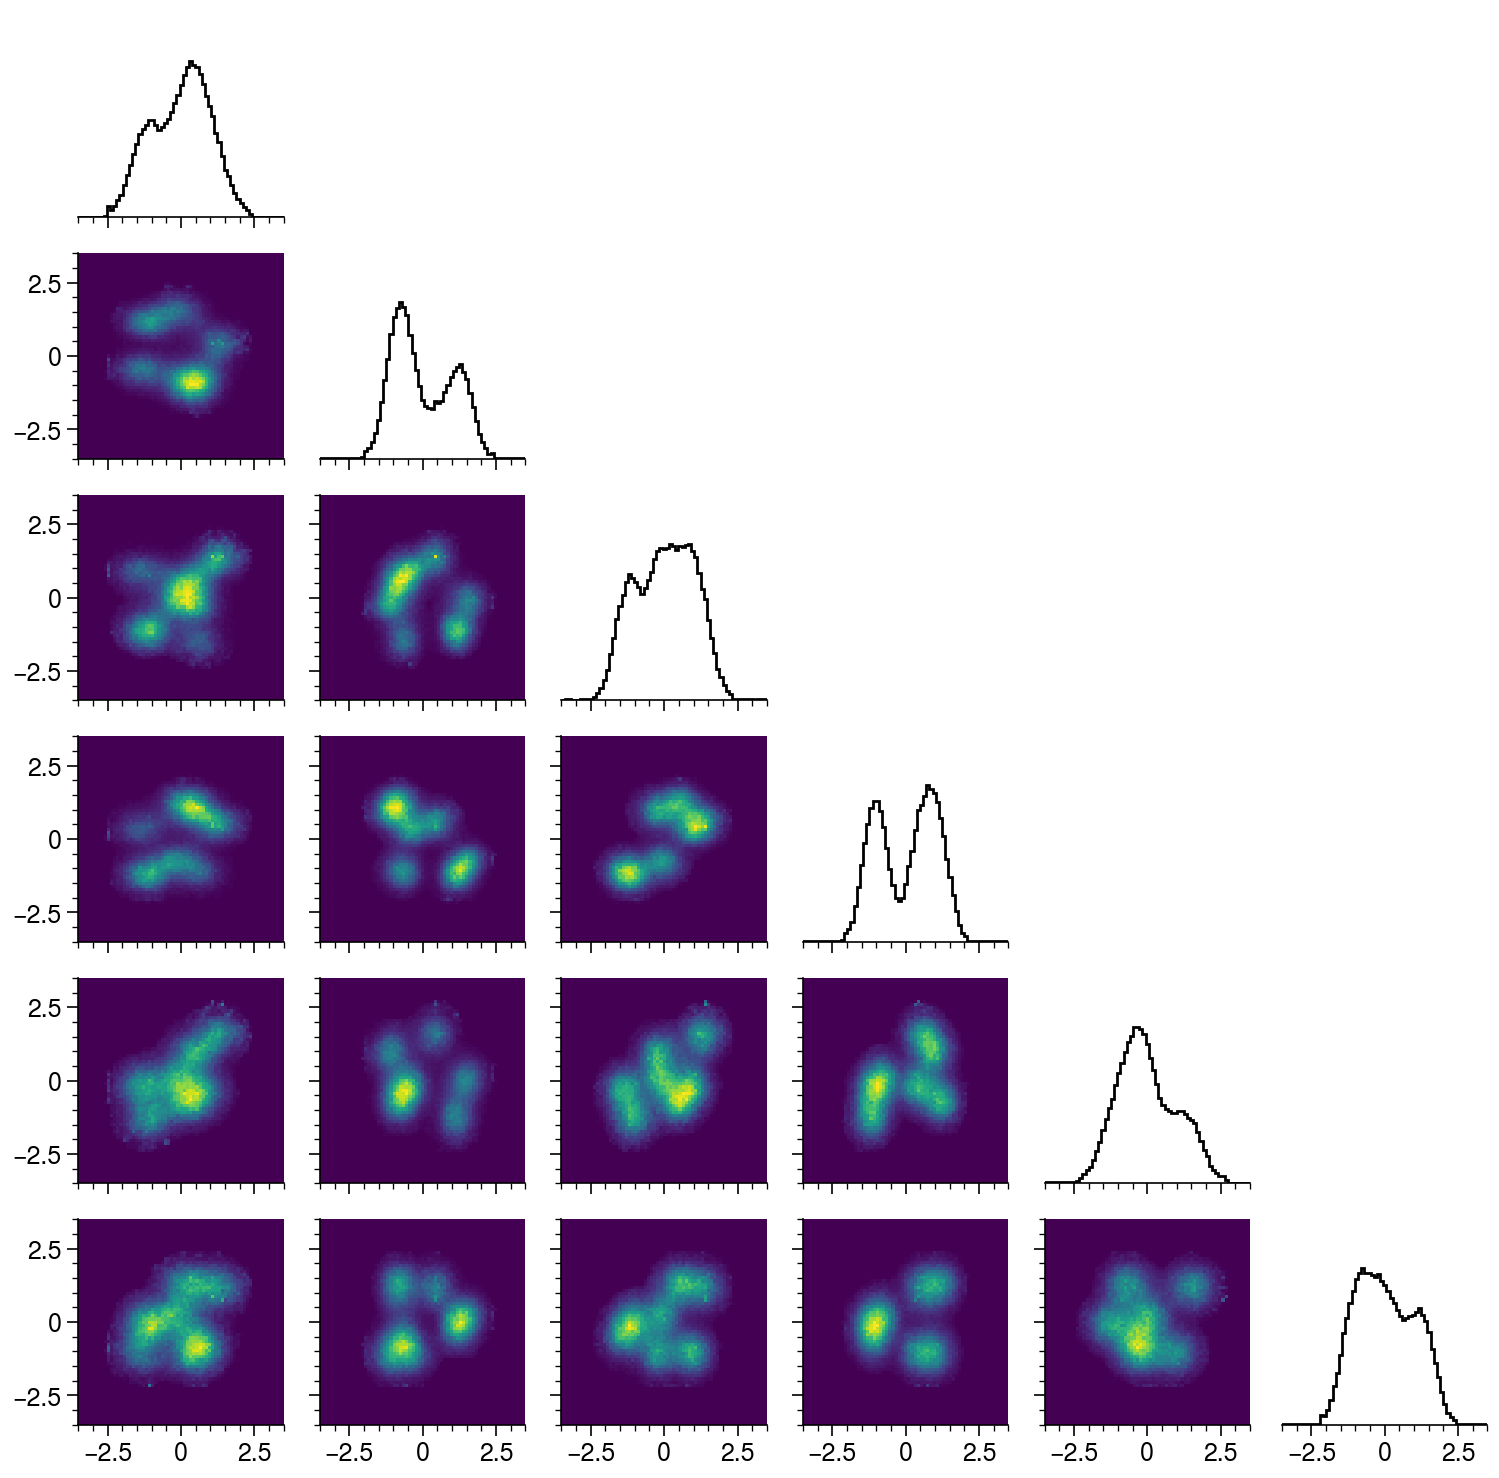

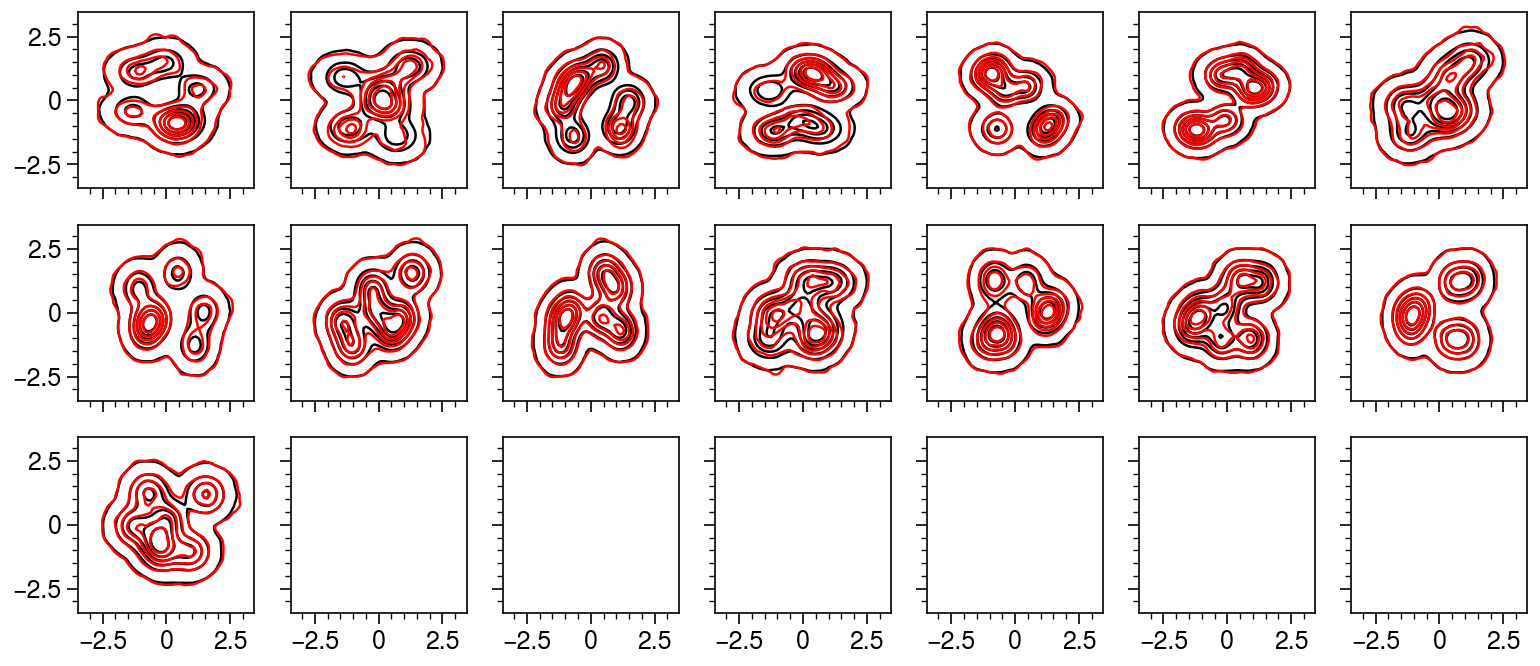

None
epoch = 2
transform=0
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                               | 63/1499 [00:00<00:02, 621.57it/s]

  8%|████████████▌                                                                                                                                        | 127/1499 [00:00<00:02, 627.43it/s]

 13%|███████████████████                                                                                                                                  | 192/1499 [00:00<00:02, 633.79it/s]

 17%|█████████████████████████▌                                                                                                                           | 257/1499 [00:00<00:01, 638.08it/s]

 22%|████████████████████████████████                                                                                                                     | 323/1499 [00:00<00:01, 642.62it/s]

 26%|██████████████████████████████████████▋                                                                                                              | 389/1499 [00:00<00:01, 648.00it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 454/1499 [00:00<00:01, 645.55it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                 | 519/1499 [00:00<00:01, 642.24it/s]

 39%|██████████████████████████████████████████████████████████                                                                                           | 584/1499 [00:00<00:01, 639.58it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                    | 649/1499 [00:01<00:01, 642.10it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 714/1499 [00:01<00:01, 644.18it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 781/1499 [00:01<00:01, 649.48it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                                | 847/1499 [00:01<00:01, 650.03it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 913/1499 [00:01<00:00, 650.39it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 979/1499 [00:01<00:00, 632.36it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1043/1499 [00:01<00:00, 617.61it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1105/1499 [00:01<00:00, 606.26it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1168/1499 [00:01<00:00, 612.03it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1230/1499 [00:01<00:00, 610.84it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1294/1499 [00:02<00:00, 616.67it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1361/1499 [00:02<00:00, 628.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1428/1499 [00:02<00:00, 639.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1492/1499 [00:02<00:00, 639.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 634.02it/s]

transform=1
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|█████▋                                                                                                                                                | 57/1499 [00:00<00:02, 569.66it/s]

  8%|████████████                                                                                                                                         | 121/1499 [00:00<00:02, 610.79it/s]

 12%|██████████████████▎                                                                                                                                  | 184/1499 [00:00<00:02, 617.63it/s]

 16%|████████████████████████▍                                                                                                                            | 246/1499 [00:00<00:02, 617.72it/s]

 21%|██████████████████████████████▉                                                                                                                      | 311/1499 [00:00<00:01, 628.76it/s]

 25%|█████████████████████████████████████▍                                                                                                               | 377/1499 [00:00<00:01, 636.40it/s]

 29%|███████████████████████████████████████████▉                                                                                                         | 442/1499 [00:00<00:01, 638.34it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                  | 506/1499 [00:00<00:01, 638.00it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                            | 571/1499 [00:00<00:01, 639.36it/s]

 42%|███████████████████████████████████████████████████████████████▎                                                                                     | 637/1499 [00:01<00:01, 642.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                               | 702/1499 [00:01<00:01, 642.36it/s]

 51%|████████████████████████████████████████████████████████████████████████████▏                                                                        | 767/1499 [00:01<00:01, 638.21it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▋                                                                  | 832/1499 [00:01<00:01, 639.78it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████                                                            | 896/1499 [00:01<00:00, 636.86it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 962/1499 [00:01<00:00, 642.43it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1028/1499 [00:01<00:00, 645.12it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1093/1499 [00:01<00:00, 640.83it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1159/1499 [00:01<00:00, 644.92it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1224/1499 [00:01<00:00, 643.77it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1289/1499 [00:02<00:00, 639.19it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1353/1499 [00:02<00:00, 636.66it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1417/1499 [00:02<00:00, 631.99it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1481/1499 [00:02<00:00, 632.31it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 635.20it/s]

transform=2
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|█████▉                                                                                                                                                | 59/1499 [00:00<00:02, 585.68it/s]

  8%|███████████▊                                                                                                                                         | 119/1499 [00:00<00:02, 593.21it/s]

 12%|█████████████████▉                                                                                                                                   | 180/1499 [00:00<00:02, 595.95it/s]

 16%|████████████████████████▎                                                                                                                            | 244/1499 [00:00<00:02, 609.82it/s]

 20%|██████████████████████████████▌                                                                                                                      | 307/1499 [00:00<00:01, 614.28it/s]

 25%|████████████████████████████████████▋                                                                                                                | 369/1499 [00:00<00:01, 613.31it/s]

 29%|██████████████████████████████████████████▊                                                                                                          | 431/1499 [00:00<00:01, 606.35it/s]

 33%|█████████████████████████████████████████████████                                                                                                    | 493/1499 [00:00<00:01, 609.25it/s]

 37%|███████████████████████████████████████████████████████▏                                                                                             | 555/1499 [00:00<00:01, 611.10it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                       | 617/1499 [00:01<00:01, 606.01it/s]

 45%|███████████████████████████████████████████████████████████████████▍                                                                                 | 678/1499 [00:01<00:01, 607.17it/s]

 49%|█████████████████████████████████████████████████████████████████████████▋                                                                           | 741/1499 [00:01<00:01, 612.37it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▏                                                                    | 807/1499 [00:01<00:01, 624.04it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▌                                                              | 871/1499 [00:01<00:00, 628.04it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 934/1499 [00:01<00:00, 628.33it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 999/1499 [00:01<00:00, 633.93it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1063/1499 [00:01<00:00, 632.59it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1129/1499 [00:01<00:00, 637.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1193/1499 [00:01<00:00, 635.77it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1259/1499 [00:02<00:00, 640.34it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1324/1499 [00:02<00:00, 637.74it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1390/1499 [00:02<00:00, 642.22it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1455/1499 [00:02<00:00, 643.23it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 624.20it/s]

transform=3
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 635.42it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 635.10it/s]

 13%|███████████████████▎                                                                                                                                 | 194/1499 [00:00<00:02, 643.90it/s]

 17%|█████████████████████████▊                                                                                                                           | 260/1499 [00:00<00:01, 649.26it/s]

 22%|████████████████████████████████▎                                                                                                                    | 325/1499 [00:00<00:01, 638.44it/s]

 26%|██████████████████████████████████████▋                                                                                                              | 389/1499 [00:00<00:01, 635.80it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 454/1499 [00:00<00:01, 640.10it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                 | 521/1499 [00:00<00:01, 646.55it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                          | 587/1499 [00:00<00:01, 649.56it/s]

 43%|████████████████████████████████████████████████████████████████▊                                                                                    | 652/1499 [00:01<00:01, 649.36it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 717/1499 [00:01<00:01, 644.82it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 782/1499 [00:01<00:01, 641.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                                | 847/1499 [00:01<00:01, 639.71it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 913/1499 [00:01<00:00, 643.54it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 978/1499 [00:01<00:00, 641.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1044/1499 [00:01<00:00, 645.76it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1109/1499 [00:01<00:00, 643.36it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1176/1499 [00:01<00:00, 649.02it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1241/1499 [00:01<00:00, 647.28it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1307/1499 [00:02<00:00, 649.96it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1372/1499 [00:02<00:00, 647.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1439/1499 [00:02<00:00, 651.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 646.08it/s]

transform=4
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                               | 65/1499 [00:00<00:02, 641.55it/s]

  9%|████████████▉                                                                                                                                        | 130/1499 [00:00<00:02, 635.58it/s]

 13%|███████████████████▎                                                                                                                                 | 194/1499 [00:00<00:02, 637.10it/s]

 17%|█████████████████████████▊                                                                                                                           | 260/1499 [00:00<00:01, 645.80it/s]

 22%|████████████████████████████████▎                                                                                                                    | 325/1499 [00:00<00:01, 645.52it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 390/1499 [00:00<00:01, 643.73it/s]

 30%|█████████████████████████████████████████████▎                                                                                                       | 456/1499 [00:00<00:01, 646.27it/s]

 35%|███████████████████████████████████████████████████▉                                                                                                 | 522/1499 [00:00<00:01, 649.85it/s]

 39%|██████████████████████████████████████████████████████████▎                                                                                          | 587/1499 [00:00<00:01, 646.95it/s]

 43%|████████████████████████████████████████████████████████████████▊                                                                                    | 652/1499 [00:01<00:01, 644.67it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 717/1499 [00:01<00:01, 642.91it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                       | 784/1499 [00:01<00:01, 648.54it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                                | 849/1499 [00:01<00:01, 648.09it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 915/1499 [00:01<00:00, 650.98it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 981/1499 [00:01<00:00, 650.30it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1047/1499 [00:01<00:00, 651.69it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1113/1499 [00:01<00:00, 653.16it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1180/1499 [00:01<00:00, 656.01it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1247/1499 [00:01<00:00, 659.09it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1314/1499 [00:02<00:00, 660.22it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1381/1499 [00:02<00:00, 660.32it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1448/1499 [00:02<00:00, 660.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 650.95it/s]

transform=5
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                               | 63/1499 [00:00<00:02, 628.89it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 639.74it/s]

 13%|███████████████████▏                                                                                                                                 | 193/1499 [00:00<00:02, 643.52it/s]

 17%|█████████████████████████▋                                                                                                                           | 258/1499 [00:00<00:01, 638.68it/s]

 22%|████████████████████████████████                                                                                                                     | 323/1499 [00:00<00:01, 642.05it/s]

 26%|██████████████████████████████████████▌                                                                                                              | 388/1499 [00:00<00:01, 644.27it/s]

 30%|█████████████████████████████████████████████                                                                                                        | 453/1499 [00:00<00:01, 645.79it/s]

 35%|███████████████████████████████████████████████████▍                                                                                                 | 518/1499 [00:00<00:01, 640.91it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                           | 583/1499 [00:00<00:01, 639.32it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                    | 649/1499 [00:01<00:01, 644.47it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                              | 714/1499 [00:01<00:01, 640.39it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                       | 779/1499 [00:01<00:01, 636.65it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                 | 843/1499 [00:01<00:01, 633.67it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 907/1499 [00:01<00:00, 635.45it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 972/1499 [00:01<00:00, 637.05it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1036/1499 [00:01<00:00, 635.37it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1102/1499 [00:01<00:00, 640.99it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1167/1499 [00:01<00:00, 640.42it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1233/1499 [00:01<00:00, 644.31it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1298/1499 [00:02<00:00, 639.40it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1364/1499 [00:02<00:00, 645.19it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1429/1499 [00:02<00:00, 643.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1494/1499 [00:02<00:00, 642.72it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 640.44it/s]

transform=6
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                               | 65/1499 [00:00<00:02, 642.16it/s]

  9%|████████████▉                                                                                                                                        | 130/1499 [00:00<00:02, 641.05it/s]

 13%|███████████████████▍                                                                                                                                 | 195/1499 [00:00<00:02, 632.72it/s]

 17%|█████████████████████████▋                                                                                                                           | 259/1499 [00:00<00:01, 632.78it/s]

 22%|████████████████████████████████▎                                                                                                                    | 325/1499 [00:00<00:01, 641.71it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 390/1499 [00:00<00:01, 641.72it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 455/1499 [00:00<00:01, 643.28it/s]

 35%|███████████████████████████████████████████████████▋                                                                                                 | 520/1499 [00:00<00:01, 640.01it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                          | 585/1499 [00:00<00:01, 640.65it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                    | 650/1499 [00:01<00:01, 640.92it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                              | 715/1499 [00:01<00:01, 641.97it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 781/1499 [00:01<00:01, 644.86it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                                | 847/1499 [00:01<00:01, 647.23it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 912/1499 [00:01<00:00, 643.57it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 977/1499 [00:01<00:00, 644.90it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1042/1499 [00:01<00:00, 642.18it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1107/1499 [00:01<00:00, 640.18it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1172/1499 [00:01<00:00, 641.58it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1238/1499 [00:01<00:00, 645.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1304/1499 [00:02<00:00, 649.79it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1369/1499 [00:02<00:00, 649.17it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1435/1499 [00:02<00:00, 651.24it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 643.57it/s]

transform=7
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                               | 63/1499 [00:00<00:02, 627.41it/s]

  8%|████████████▌                                                                                                                                        | 127/1499 [00:00<00:02, 630.35it/s]

 13%|██████████████████▉                                                                                                                                  | 191/1499 [00:00<00:02, 629.79it/s]

 17%|█████████████████████████▏                                                                                                                           | 254/1499 [00:00<00:01, 627.78it/s]

 21%|███████████████████████████████▌                                                                                                                     | 317/1499 [00:00<00:01, 627.20it/s]

 25%|█████████████████████████████████████▉                                                                                                               | 382/1499 [00:00<00:01, 633.96it/s]

 30%|████████████████████████████████████████████▎                                                                                                        | 446/1499 [00:00<00:01, 631.95it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                  | 510/1499 [00:00<00:01, 632.68it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                           | 575/1499 [00:00<00:01, 637.32it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                     | 640/1499 [00:01<00:01, 640.27it/s]

 47%|██████████████████████████████████████████████████████████████████████                                                                               | 705/1499 [00:01<00:01, 640.45it/s]

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                        | 770/1499 [00:01<00:01, 635.04it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                  | 834/1499 [00:01<00:01, 635.53it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 899/1499 [00:01<00:00, 639.43it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 963/1499 [00:01<00:00, 638.42it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1027/1499 [00:01<00:00, 638.16it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1091/1499 [00:01<00:00, 638.68it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1155/1499 [00:01<00:00, 638.59it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1219/1499 [00:01<00:00, 638.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1284/1499 [00:02<00:00, 639.46it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1348/1499 [00:02<00:00, 635.30it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1412/1499 [00:02<00:00, 634.49it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1477/1499 [00:02<00:00, 638.20it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 635.75it/s]

transform=8
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                               | 65/1499 [00:00<00:02, 643.38it/s]

  9%|████████████▉                                                                                                                                        | 130/1499 [00:00<00:02, 645.50it/s]

 13%|███████████████████▍                                                                                                                                 | 195/1499 [00:00<00:02, 637.00it/s]

 17%|█████████████████████████▋                                                                                                                           | 259/1499 [00:00<00:01, 634.65it/s]

 22%|████████████████████████████████▏                                                                                                                    | 324/1499 [00:00<00:01, 639.26it/s]

 26%|██████████████████████████████████████▋                                                                                                              | 389/1499 [00:00<00:01, 642.66it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 454/1499 [00:00<00:01, 639.40it/s]

 35%|███████████████████████████████████████████████████▋                                                                                                 | 520/1499 [00:00<00:01, 643.90it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                          | 585/1499 [00:00<00:01, 641.33it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 651/1499 [00:01<00:01, 645.55it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 718/1499 [00:01<00:01, 651.02it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                       | 784/1499 [00:01<00:01, 647.73it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                                | 850/1499 [00:01<00:00, 650.17it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 917/1499 [00:01<00:00, 653.46it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 984/1499 [00:01<00:00, 655.46it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1051/1499 [00:01<00:00, 658.05it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1117/1499 [00:01<00:00, 655.15it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1183/1499 [00:01<00:00, 651.98it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1249/1499 [00:01<00:00, 647.31it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1316/1499 [00:02<00:00, 651.31it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1383/1499 [00:02<00:00, 655.74it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1450/1499 [00:02<00:00, 657.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 649.54it/s]

transform=9
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                               | 65/1499 [00:00<00:02, 646.22it/s]

  9%|█████████████                                                                                                                                        | 131/1499 [00:00<00:02, 648.86it/s]

 13%|███████████████████▍                                                                                                                                 | 196/1499 [00:00<00:02, 643.96it/s]

 17%|█████████████████████████▉                                                                                                                           | 261/1499 [00:00<00:01, 646.20it/s]

 22%|████████████████████████████████▍                                                                                                                    | 326/1499 [00:00<00:01, 646.96it/s]

 26%|██████████████████████████████████████▉                                                                                                              | 392/1499 [00:00<00:01, 649.10it/s]

 31%|█████████████████████████████████████████████▌                                                                                                       | 458/1499 [00:00<00:01, 651.90it/s]

 35%|████████████████████████████████████████████████████                                                                                                 | 524/1499 [00:00<00:01, 646.88it/s]

 39%|██████████████████████████████████████████████████████████▋                                                                                          | 590/1499 [00:00<00:01, 648.69it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                    | 655/1499 [00:01<00:01, 645.27it/s]

 48%|███████████████████████████████████████████████████████████████████████▌                                                                             | 720/1499 [00:01<00:01, 645.32it/s]

 52%|██████████████████████████████████████████████████████████████████████████████▏                                                                      | 786/1499 [00:01<00:01, 649.51it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▌                                                                | 851/1499 [00:01<00:01, 645.61it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 916/1499 [00:01<00:00, 643.76it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 982/1499 [00:01<00:00, 645.72it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1047/1499 [00:01<00:00, 637.70it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1111/1499 [00:01<00:00, 634.85it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1176/1499 [00:01<00:00, 638.03it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1240/1499 [00:01<00:00, 636.56it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1307/1499 [00:02<00:00, 644.04it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1372/1499 [00:02<00:00, 645.67it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1439/1499 [00:02<00:00, 651.59it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 645.87it/s]

transform=10
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                               | 63/1499 [00:00<00:02, 628.70it/s]

  8%|████████████▌                                                                                                                                        | 127/1499 [00:00<00:02, 629.67it/s]

 13%|███████████████████                                                                                                                                  | 192/1499 [00:00<00:02, 635.36it/s]

 17%|█████████████████████████▋                                                                                                                           | 258/1499 [00:00<00:01, 641.73it/s]

 22%|████████████████████████████████                                                                                                                     | 323/1499 [00:00<00:01, 636.88it/s]

 26%|██████████████████████████████████████▍                                                                                                              | 387/1499 [00:00<00:01, 634.45it/s]

 30%|████████████████████████████████████████████▊                                                                                                        | 451/1499 [00:00<00:01, 631.56it/s]

 34%|███████████████████████████████████████████████████▏                                                                                                 | 515/1499 [00:00<00:01, 628.89it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 580/1499 [00:00<00:01, 633.03it/s]

 43%|████████████████████████████████████████████████████████████████                                                                                     | 644/1499 [00:01<00:01, 634.86it/s]

 47%|██████████████████████████████████████████████████████████████████████▍                                                                              | 709/1499 [00:01<00:01, 638.95it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                        | 775/1499 [00:01<00:01, 641.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                 | 840/1499 [00:01<00:01, 641.46it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                           | 906/1499 [00:01<00:00, 645.00it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 971/1499 [00:01<00:00, 640.81it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1037/1499 [00:01<00:00, 643.63it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1102/1499 [00:01<00:00, 644.90it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1167/1499 [00:01<00:00, 642.16it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1232/1499 [00:01<00:00, 643.59it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1297/1499 [00:02<00:00, 642.13it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1362/1499 [00:02<00:00, 641.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1428/1499 [00:02<00:00, 644.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1493/1499 [00:02<00:00, 644.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 639.49it/s]

transform=11
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▏                                                                                                                                               | 62/1499 [00:00<00:02, 618.09it/s]

  8%|████████████▎                                                                                                                                        | 124/1499 [00:00<00:02, 617.71it/s]

 13%|██████████████████▋                                                                                                                                  | 188/1499 [00:00<00:02, 625.66it/s]

 17%|█████████████████████████▏                                                                                                                           | 253/1499 [00:00<00:01, 630.61it/s]

 21%|███████████████████████████████▌                                                                                                                     | 317/1499 [00:00<00:01, 626.62it/s]

 25%|█████████████████████████████████████▊                                                                                                               | 380/1499 [00:00<00:01, 625.60it/s]

 30%|████████████████████████████████████████████▏                                                                                                        | 445/1499 [00:00<00:01, 632.69it/s]

 34%|██████████████████████████████████████████████████▋                                                                                                  | 510/1499 [00:00<00:01, 637.16it/s]

 38%|█████████████████████████████████████████████████████████                                                                                            | 574/1499 [00:00<00:01, 637.47it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                     | 638/1499 [00:01<00:01, 636.83it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                               | 702/1499 [00:01<00:01, 636.79it/s]

 51%|████████████████████████████████████████████████████████████████████████████▏                                                                        | 766/1499 [00:01<00:01, 627.00it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                  | 829/1499 [00:01<00:01, 622.21it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 892/1499 [00:01<00:00, 621.01it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 955/1499 [00:01<00:00, 622.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1018/1499 [00:01<00:00, 618.57it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1081/1499 [00:01<00:00, 621.08it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1144/1499 [00:01<00:00, 612.83it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1206/1499 [00:01<00:00, 607.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1267/1499 [00:02<00:00, 603.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1328/1499 [00:02<00:00, 602.44it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1390/1499 [00:02<00:00, 605.42it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1451/1499 [00:02<00:00, 605.38it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 619.11it/s]

transform=12
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████                                                                                                                                                | 61/1499 [00:00<00:02, 607.32it/s]

  8%|████████████▏                                                                                                                                        | 122/1499 [00:00<00:02, 608.05it/s]

 12%|██████████████████▏                                                                                                                                  | 183/1499 [00:00<00:02, 603.59it/s]

 16%|████████████████████████▎                                                                                                                            | 244/1499 [00:00<00:02, 605.25it/s]

 20%|██████████████████████████████▍                                                                                                                      | 306/1499 [00:00<00:01, 609.96it/s]

 25%|████████████████████████████████████▋                                                                                                                | 369/1499 [00:00<00:01, 614.20it/s]

 29%|██████████████████████████████████████████▊                                                                                                          | 431/1499 [00:00<00:01, 610.37it/s]

 33%|█████████████████████████████████████████████████                                                                                                    | 493/1499 [00:00<00:01, 608.64it/s]

 37%|███████████████████████████████████████████████████████                                                                                              | 554/1499 [00:00<00:01, 602.74it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                       | 617/1499 [00:01<00:01, 608.59it/s]

 45%|███████████████████████████████████████████████████████████████████▊                                                                                 | 682/1499 [00:01<00:01, 618.57it/s]

 50%|██████████████████████████████████████████████████████████████████████████▎                                                                          | 748/1499 [00:01<00:01, 629.18it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▌                                                                    | 811/1499 [00:01<00:01, 629.37it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▏                                                             | 877/1499 [00:01<00:00, 635.75it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 943/1499 [00:01<00:00, 641.84it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1008/1499 [00:01<00:00, 643.81it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1073/1499 [00:01<00:00, 645.25it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1140/1499 [00:01<00:00, 650.30it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1206/1499 [00:01<00:00, 646.04it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1272/1499 [00:02<00:00, 647.18it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1337/1499 [00:02<00:00, 644.06it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1403/1499 [00:02<00:00, 648.38it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1468/1499 [00:02<00:00, 644.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 630.26it/s]

transform=13
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 631.89it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 636.50it/s]

 13%|███████████████████                                                                                                                                  | 192/1499 [00:00<00:02, 630.89it/s]

 17%|█████████████████████████▋                                                                                                                           | 258/1499 [00:00<00:01, 639.20it/s]

 22%|████████████████████████████████▎                                                                                                                    | 325/1499 [00:00<00:01, 646.51it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 391/1499 [00:00<00:01, 648.94it/s]

 30%|█████████████████████████████████████████████▎                                                                                                       | 456/1499 [00:00<00:01, 647.54it/s]

 35%|███████████████████████████████████████████████████▊                                                                                                 | 521/1499 [00:00<00:01, 645.67it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                          | 586/1499 [00:00<00:01, 641.08it/s]

 43%|████████████████████████████████████████████████████████████████▋                                                                                    | 651/1499 [00:01<00:01, 643.65it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 718/1499 [00:01<00:01, 649.28it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▉                                                                       | 784/1499 [00:01<00:01, 652.05it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▍                                                                | 850/1499 [00:01<00:00, 650.51it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████                                                          | 916/1499 [00:01<00:00, 652.08it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 982/1499 [00:01<00:00, 653.40it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1048/1499 [00:01<00:00, 654.76it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1115/1499 [00:01<00:00, 657.72it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1181/1499 [00:01<00:00, 658.19it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1247/1499 [00:01<00:00, 648.19it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1312/1499 [00:02<00:00, 647.28it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1378/1499 [00:02<00:00, 650.12it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1444/1499 [00:02<00:00, 650.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 648.66it/s]

transform=14
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 638.65it/s]

  9%|████████████▊                                                                                                                                        | 129/1499 [00:00<00:02, 641.58it/s]

 13%|███████████████████▎                                                                                                                                 | 194/1499 [00:00<00:02, 644.44it/s]

 17%|█████████████████████████▋                                                                                                                           | 259/1499 [00:00<00:01, 638.36it/s]

 22%|████████████████████████████████                                                                                                                     | 323/1499 [00:00<00:01, 636.05it/s]

 26%|██████████████████████████████████████▍                                                                                                              | 387/1499 [00:00<00:01, 636.05it/s]

 30%|████████████████████████████████████████████▊                                                                                                        | 451/1499 [00:00<00:01, 636.61it/s]

 34%|███████████████████████████████████████████████████▍                                                                                                 | 517/1499 [00:00<00:01, 641.56it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                           | 582/1499 [00:00<00:01, 642.12it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                    | 647/1499 [00:01<00:01, 640.47it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                              | 713/1499 [00:01<00:01, 643.33it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                       | 779/1499 [00:01<00:01, 646.67it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                 | 844/1499 [00:01<00:01, 642.29it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 909/1499 [00:01<00:00, 641.16it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 975/1499 [00:01<00:00, 644.49it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1040/1499 [00:01<00:00, 645.82it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1107/1499 [00:01<00:00, 650.62it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1173/1499 [00:01<00:00, 650.90it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1239/1499 [00:01<00:00, 650.86it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1305/1499 [00:02<00:00, 648.63it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1370/1499 [00:02<00:00, 647.12it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1435/1499 [00:02<00:00, 642.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 643.39it/s]

  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▏                                                                                                                                               | 62/1499 [00:00<00:02, 618.55it/s]

  8%|████████████▌                                                                                                                                        | 126/1499 [00:00<00:02, 626.59it/s]

 13%|██████████████████▉                                                                                                                                  | 190/1499 [00:00<00:02, 631.07it/s]

 17%|█████████████████████████▏                                                                                                                           | 254/1499 [00:00<00:01, 633.40it/s]

 21%|███████████████████████████████▌                                                                                                                     | 318/1499 [00:00<00:01, 635.27it/s]

 25%|█████████████████████████████████████▉                                                                                                               | 382/1499 [00:00<00:01, 632.64it/s]

 30%|████████████████████████████████████████████▎                                                                                                        | 446/1499 [00:00<00:01, 632.32it/s]

 34%|██████████████████████████████████████████████████▊                                                                                                  | 511/1499 [00:00<00:01, 635.31it/s]

 38%|█████████████████████████████████████████████████████████▏                                                                                           | 575/1499 [00:00<00:01, 630.06it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                     | 639/1499 [00:01<00:01, 623.03it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                               | 702/1499 [00:01<00:01, 622.34it/s]

 51%|████████████████████████████████████████████████████████████████████████████▏                                                                        | 766/1499 [00:01<00:01, 625.67it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                  | 830/1499 [00:01<00:01, 628.81it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 893/1499 [00:01<00:00, 628.57it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 957/1499 [00:01<00:00, 631.55it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1021/1499 [00:01<00:00, 629.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1085/1499 [00:01<00:00, 629.72it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1148/1499 [00:01<00:00, 620.51it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1211/1499 [00:01<00:00, 613.86it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1275/1499 [00:02<00:00, 620.66it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1338/1499 [00:02<00:00, 612.71it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1400/1499 [00:02<00:00, 605.66it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1461/1499 [00:02<00:00, 602.96it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 621.25it/s]

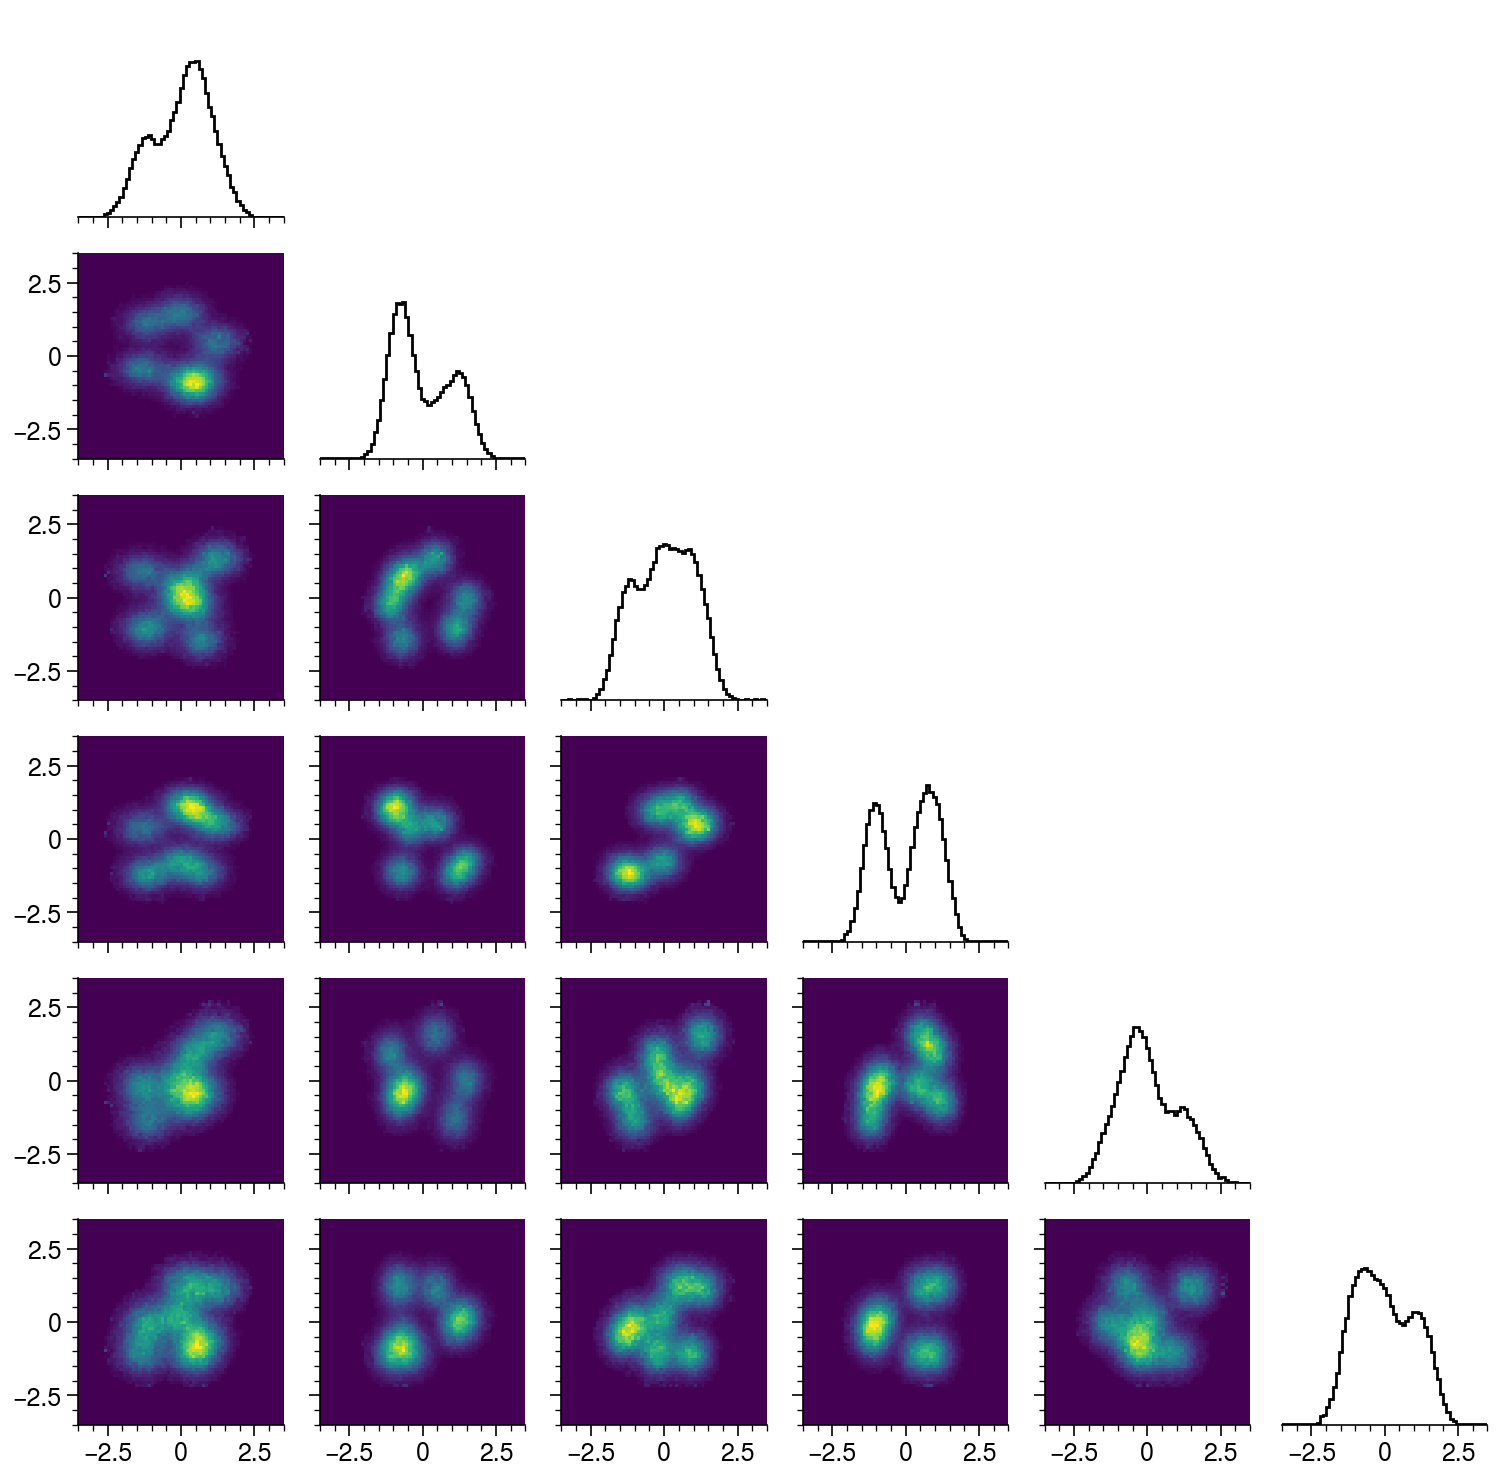

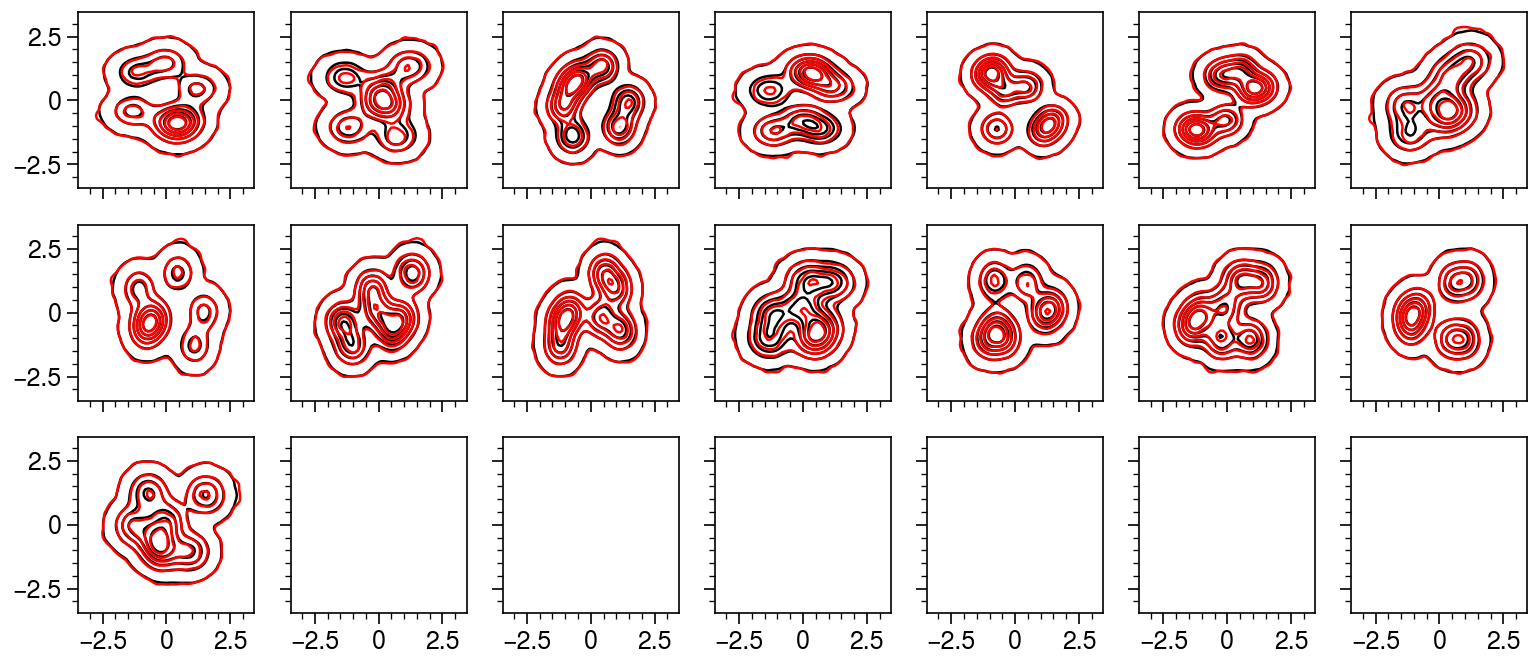

None
epoch = 3
transform=0
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                               | 65/1499 [00:00<00:02, 647.92it/s]

  9%|████████████▉                                                                                                                                        | 130/1499 [00:00<00:02, 642.52it/s]

 13%|███████████████████▍                                                                                                                                 | 195/1499 [00:00<00:02, 638.68it/s]

 17%|█████████████████████████▋                                                                                                                           | 259/1499 [00:00<00:01, 636.53it/s]

 22%|████████████████████████████████▎                                                                                                                    | 325/1499 [00:00<00:01, 642.77it/s]

 26%|██████████████████████████████████████▊                                                                                                              | 390/1499 [00:00<00:01, 627.86it/s]

 30%|█████████████████████████████████████████████                                                                                                        | 453/1499 [00:00<00:01, 627.51it/s]

 34%|███████████████████████████████████████████████████▍                                                                                                 | 517/1499 [00:00<00:01, 628.57it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 580/1499 [00:00<00:01, 626.42it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                    | 646/1499 [00:01<00:01, 633.81it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                              | 710/1499 [00:01<00:01, 635.25it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                        | 774/1499 [00:01<00:01, 634.65it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                 | 839/1499 [00:01<00:01, 636.66it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 903/1499 [00:01<00:00, 635.50it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 967/1499 [00:01<00:00, 635.21it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1031/1499 [00:01<00:00, 633.98it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1095/1499 [00:01<00:00, 634.61it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1159/1499 [00:01<00:00, 631.79it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1223/1499 [00:01<00:00, 631.28it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1287/1499 [00:02<00:00, 630.94it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1351/1499 [00:02<00:00, 631.39it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1416/1499 [00:02<00:00, 636.63it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1480/1499 [00:02<00:00, 635.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 633.91it/s]

transform=1
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                               | 63/1499 [00:00<00:02, 628.62it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 637.40it/s]

 13%|███████████████████                                                                                                                                  | 192/1499 [00:00<00:02, 628.88it/s]

 17%|█████████████████████████▍                                                                                                                           | 256/1499 [00:00<00:01, 631.94it/s]

 21%|███████████████████████████████▊                                                                                                                     | 320/1499 [00:00<00:01, 626.83it/s]

 26%|██████████████████████████████████████▏                                                                                                              | 384/1499 [00:00<00:01, 629.63it/s]

 30%|████████████████████████████████████████████▍                                                                                                        | 447/1499 [00:00<00:01, 624.33it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                  | 512/1499 [00:00<00:01, 632.22it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                           | 578/1499 [00:00<00:01, 638.28it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                     | 642/1499 [00:01<00:01, 637.12it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 707/1499 [00:01<00:01, 640.61it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                        | 772/1499 [00:01<00:01, 643.21it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▏                                                                 | 837/1499 [00:01<00:01, 637.44it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 903/1499 [00:01<00:00, 641.71it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 968/1499 [00:01<00:00, 640.36it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1033/1499 [00:01<00:00, 640.74it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1098/1499 [00:01<00:00, 634.49it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1162/1499 [00:01<00:00, 635.19it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1228/1499 [00:01<00:00, 639.28it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1292/1499 [00:02<00:00, 637.98it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1357/1499 [00:02<00:00, 640.70it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1422/1499 [00:02<00:00, 639.80it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1486/1499 [00:02<00:00, 635.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 636.20it/s]

transform=2
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                               | 63/1499 [00:00<00:02, 628.51it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 637.21it/s]

 13%|███████████████████                                                                                                                                  | 192/1499 [00:00<00:02, 636.08it/s]

 17%|█████████████████████████▍                                                                                                                           | 256/1499 [00:00<00:01, 630.33it/s]

 21%|███████████████████████████████▊                                                                                                                     | 320/1499 [00:00<00:01, 631.44it/s]

 26%|██████████████████████████████████████▏                                                                                                              | 384/1499 [00:00<00:01, 629.44it/s]

 30%|████████████████████████████████████████████▌                                                                                                        | 448/1499 [00:00<00:01, 631.63it/s]

 34%|███████████████████████████████████████████████████                                                                                                  | 514/1499 [00:00<00:01, 637.41it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                           | 578/1499 [00:00<00:01, 636.27it/s]

 43%|███████████████████████████████████████████████████████████████▉                                                                                     | 643/1499 [00:01<00:01, 639.97it/s]

 47%|██████████████████████████████████████████████████████████████████████▍                                                                              | 709/1499 [00:01<00:01, 642.96it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                        | 774/1499 [00:01<00:01, 639.05it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                 | 840/1499 [00:01<00:01, 642.54it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 905/1499 [00:01<00:00, 644.33it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 970/1499 [00:01<00:00, 645.85it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1035/1499 [00:01<00:00, 635.57it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1099/1499 [00:01<00:00, 629.41it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1162/1499 [00:01<00:00, 627.06it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1226/1499 [00:01<00:00, 630.53it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1290/1499 [00:02<00:00, 623.41it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1353/1499 [00:02<00:00, 616.11it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1415/1499 [00:02<00:00, 613.35it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1479/1499 [00:02<00:00, 619.17it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 631.33it/s]

transform=3
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                               | 63/1499 [00:00<00:02, 626.30it/s]

  8%|████████████▌                                                                                                                                        | 126/1499 [00:00<00:02, 619.18it/s]

 13%|██████████████████▉                                                                                                                                  | 191/1499 [00:00<00:02, 630.17it/s]

 17%|█████████████████████████▎                                                                                                                           | 255/1499 [00:00<00:01, 626.57it/s]

 21%|███████████████████████████████▌                                                                                                                     | 318/1499 [00:00<00:01, 624.89it/s]

 26%|██████████████████████████████████████▏                                                                                                              | 384/1499 [00:00<00:01, 634.03it/s]

 30%|████████████████████████████████████████████▊                                                                                                        | 451/1499 [00:00<00:01, 642.84it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 516/1499 [00:00<00:01, 642.41it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                           | 581/1499 [00:00<00:01, 642.62it/s]

 43%|████████████████████████████████████████████████████████████████▏                                                                                    | 646/1499 [00:01<00:01, 638.36it/s]

 47%|██████████████████████████████████████████████████████████████████████▌                                                                              | 710/1499 [00:01<00:01, 637.51it/s]

 52%|████████████████████████████████████████████████████████████████████████████▉                                                                        | 774/1499 [00:01<00:01, 635.54it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                 | 838/1499 [00:01<00:01, 628.23it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 902/1499 [00:01<00:00, 628.86it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 966/1499 [00:01<00:00, 631.67it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1030/1499 [00:01<00:00, 631.59it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1094/1499 [00:01<00:00, 632.19it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1159/1499 [00:01<00:00, 635.42it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1223/1499 [00:01<00:00, 625.60it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1286/1499 [00:02<00:00, 622.93it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1349/1499 [00:02<00:00, 616.02it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1411/1499 [00:02<00:00, 609.47it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1474/1499 [00:02<00:00, 615.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 628.49it/s]

transform=4
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                               | 63/1499 [00:00<00:02, 621.91it/s]

  8%|████████████▌                                                                                                                                        | 126/1499 [00:00<00:02, 615.96it/s]

 13%|██████████████████▊                                                                                                                                  | 189/1499 [00:00<00:02, 620.83it/s]

 17%|█████████████████████████▏                                                                                                                           | 253/1499 [00:00<00:01, 625.89it/s]

 21%|███████████████████████████████▌                                                                                                                     | 317/1499 [00:00<00:01, 628.81it/s]

 25%|█████████████████████████████████████▊                                                                                                               | 380/1499 [00:00<00:01, 625.61it/s]

 30%|████████████████████████████████████████████▏                                                                                                        | 445/1499 [00:00<00:01, 632.16it/s]

 34%|██████████████████████████████████████████████████▌                                                                                                  | 509/1499 [00:00<00:01, 629.33it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                            | 572/1499 [00:00<00:01, 627.26it/s]

 42%|███████████████████████████████████████████████████████████████▎                                                                                     | 637/1499 [00:01<00:01, 631.50it/s]

 47%|█████████████████████████████████████████████████████████████████████▊                                                                               | 702/1499 [00:01<00:01, 637.06it/s]

 51%|████████████████████████████████████████████████████████████████████████████▏                                                                        | 766/1499 [00:01<00:01, 634.09it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                  | 830/1499 [00:01<00:01, 633.13it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 894/1499 [00:01<00:00, 630.80it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 958/1499 [00:01<00:00, 631.55it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1022/1499 [00:01<00:00, 631.96it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1088/1499 [00:01<00:00, 637.14it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1152/1499 [00:01<00:00, 631.01it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1216/1499 [00:01<00:00, 627.62it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1279/1499 [00:02<00:00, 626.17it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1343/1499 [00:02<00:00, 629.02it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1410/1499 [00:02<00:00, 639.42it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1475/1499 [00:02<00:00, 641.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 630.86it/s]

transform=5
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████                                                                                                                                                | 60/1499 [00:00<00:02, 593.71it/s]

  8%|███████████▉                                                                                                                                         | 120/1499 [00:00<00:02, 593.88it/s]

 12%|█████████████████▉                                                                                                                                   | 180/1499 [00:00<00:02, 594.57it/s]

 16%|████████████████████████                                                                                                                             | 242/1499 [00:00<00:02, 603.55it/s]

 20%|██████████████████████████████                                                                                                                       | 303/1499 [00:00<00:01, 600.76it/s]

 24%|████████████████████████████████████▏                                                                                                                | 364/1499 [00:00<00:01, 594.02it/s]

 28%|██████████████████████████████████████████▏                                                                                                          | 424/1499 [00:00<00:01, 595.16it/s]

 32%|████████████████████████████████████████████████▎                                                                                                    | 486/1499 [00:00<00:01, 601.50it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                              | 549/1499 [00:00<00:01, 607.46it/s]

 41%|████████████████████████████████████████████████████████████▋                                                                                        | 610/1499 [00:01<00:01, 604.87it/s]

 45%|██████████████████████████████████████████████████████████████████▋                                                                                  | 671/1499 [00:01<00:01, 604.31it/s]

 49%|████████████████████████████████████████████████████████████████████████▊                                                                            | 733/1499 [00:01<00:01, 605.98it/s]

 53%|███████████████████████████████████████████████████████████████████████████████                                                                      | 796/1499 [00:01<00:01, 610.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████▎                                                               | 858/1499 [00:01<00:01, 611.91it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 921/1499 [00:01<00:00, 613.09it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 985/1499 [00:01<00:00, 620.60it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1048/1499 [00:01<00:00, 617.11it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1110/1499 [00:01<00:00, 614.09it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1173/1499 [00:01<00:00, 618.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1237/1499 [00:02<00:00, 624.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1300/1499 [00:02<00:00, 620.84it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1364/1499 [00:02<00:00, 624.39it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1427/1499 [00:02<00:00, 616.59it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1489/1499 [00:02<00:00, 614.37it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 610.05it/s]

transform=6
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 637.72it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 630.13it/s]

 13%|███████████████████                                                                                                                                  | 192/1499 [00:00<00:02, 631.60it/s]

 17%|█████████████████████████▋                                                                                                                           | 258/1499 [00:00<00:01, 638.87it/s]

 22%|████████████████████████████████▏                                                                                                                    | 324/1499 [00:00<00:01, 642.71it/s]

 26%|██████████████████████████████████████▋                                                                                                              | 389/1499 [00:00<00:01, 640.29it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 454/1499 [00:00<00:01, 640.66it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                 | 519/1499 [00:00<00:01, 639.17it/s]

 39%|█████████████████████████████████████████████████████████▉                                                                                           | 583/1499 [00:00<00:01, 638.34it/s]

 43%|████████████████████████████████████████████████████████████████▎                                                                                    | 647/1499 [00:01<00:01, 637.43it/s]

 47%|██████████████████████████████████████████████████████████████████████▊                                                                              | 712/1499 [00:01<00:01, 638.71it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▏                                                                       | 776/1499 [00:01<00:01, 636.37it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                 | 840/1499 [00:01<00:01, 637.17it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 905/1499 [00:01<00:00, 640.40it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 970/1499 [00:01<00:00, 641.09it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1036/1499 [00:01<00:00, 644.80it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1102/1499 [00:01<00:00, 648.00it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1169/1499 [00:01<00:00, 651.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1235/1499 [00:01<00:00, 648.85it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1300/1499 [00:02<00:00, 646.75it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1365/1499 [00:02<00:00, 643.91it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1431/1499 [00:02<00:00, 646.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1498/1499 [00:02<00:00, 650.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 642.62it/s]

transform=7
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████                                                                                                                                                | 61/1499 [00:00<00:02, 603.16it/s]

  8%|████████████▏                                                                                                                                        | 122/1499 [00:00<00:02, 598.09it/s]

 12%|██████████████████                                                                                                                                   | 182/1499 [00:00<00:02, 593.76it/s]

 16%|████████████████████████▏                                                                                                                            | 243/1499 [00:00<00:02, 598.22it/s]

 20%|██████████████████████████████▎                                                                                                                      | 305/1499 [00:00<00:01, 604.41it/s]

 24%|████████████████████████████████████▍                                                                                                                | 366/1499 [00:00<00:01, 603.73it/s]

 29%|██████████████████████████████████████████▋                                                                                                          | 429/1499 [00:00<00:01, 609.17it/s]

 33%|████████████████████████████████████████████████▉                                                                                                    | 492/1499 [00:00<00:01, 614.84it/s]

 37%|███████████████████████████████████████████████████████▎                                                                                             | 556/1499 [00:00<00:01, 621.36it/s]

 41%|█████████████████████████████████████████████████████████████▋                                                                                       | 620/1499 [00:01<00:01, 626.19it/s]

 46%|████████████████████████████████████████████████████████████████████▎                                                                                | 687/1499 [00:01<00:01, 636.52it/s]

 50%|██████████████████████████████████████████████████████████████████████████▋                                                                          | 752/1499 [00:01<00:01, 638.76it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                   | 817/1499 [00:01<00:01, 639.75it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▋                                                             | 882/1499 [00:01<00:00, 641.77it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 947/1499 [00:01<00:00, 636.27it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1011/1499 [00:01<00:00, 635.99it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1075/1499 [00:01<00:00, 631.65it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1139/1499 [00:01<00:00, 629.18it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1202/1499 [00:01<00:00, 627.61it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1265/1499 [00:02<00:00, 621.24it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1328/1499 [00:02<00:00, 616.57it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1391/1499 [00:02<00:00, 618.14it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1454/1499 [00:02<00:00, 618.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 622.32it/s]

transform=8
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 632.51it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 632.79it/s]

 13%|███████████████████▎                                                                                                                                 | 194/1499 [00:00<00:02, 640.46it/s]

 17%|█████████████████████████▋                                                                                                                           | 259/1499 [00:00<00:01, 636.55it/s]

 22%|████████████████████████████████                                                                                                                     | 323/1499 [00:00<00:01, 635.71it/s]

 26%|██████████████████████████████████████▍                                                                                                              | 387/1499 [00:00<00:01, 634.98it/s]

 30%|████████████████████████████████████████████▊                                                                                                        | 451/1499 [00:00<00:01, 630.65it/s]

 34%|███████████████████████████████████████████████████▏                                                                                                 | 515/1499 [00:00<00:01, 614.04it/s]

 38%|█████████████████████████████████████████████████████████▎                                                                                           | 577/1499 [00:00<00:01, 601.80it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                     | 638/1499 [00:01<00:01, 591.82it/s]

 47%|█████████████████████████████████████████████████████████████████████▍                                                                               | 698/1499 [00:01<00:01, 587.01it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                         | 757/1499 [00:01<00:01, 585.47it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                   | 818/1499 [00:01<00:01, 590.15it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▎                                                             | 878/1499 [00:01<00:01, 586.80it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 937/1499 [00:01<00:00, 585.13it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 996/1499 [00:01<00:00, 583.91it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1055/1499 [00:01<00:00, 583.81it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1114/1499 [00:01<00:00, 580.33it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1173/1499 [00:01<00:00, 578.87it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1232/1499 [00:02<00:00, 578.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1291/1499 [00:02<00:00, 581.46it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1350/1499 [00:02<00:00, 577.08it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1409/1499 [00:02<00:00, 579.09it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1468/1499 [00:02<00:00, 581.66it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 594.77it/s]

transform=9
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|█████▌                                                                                                                                                | 55/1499 [00:00<00:02, 543.62it/s]

  7%|███████████▏                                                                                                                                         | 112/1499 [00:00<00:02, 557.31it/s]

 11%|████████████████▊                                                                                                                                    | 169/1499 [00:00<00:02, 561.45it/s]

 15%|██████████████████████▍                                                                                                                              | 226/1499 [00:00<00:02, 563.64it/s]

 19%|████████████████████████████▏                                                                                                                        | 283/1499 [00:00<00:02, 564.75it/s]

 23%|█████████████████████████████████▊                                                                                                                   | 340/1499 [00:00<00:02, 560.29it/s]

 27%|███████████████████████████████████████▌                                                                                                             | 398/1499 [00:00<00:01, 565.57it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 455/1499 [00:00<00:01, 564.05it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                  | 513/1499 [00:00<00:01, 568.80it/s]

 38%|████████████████████████████████████████████████████████▊                                                                                            | 572/1499 [00:01<00:01, 575.21it/s]

 42%|██████████████████████████████████████████████████████████████▌                                                                                      | 630/1499 [00:01<00:01, 576.64it/s]

 46%|████████████████████████████████████████████████████████████████████▍                                                                                | 689/1499 [00:01<00:01, 577.68it/s]

 50%|██████████████████████████████████████████████████████████████████████████▎                                                                          | 747/1499 [00:01<00:01, 575.91it/s]

 54%|████████████████████████████████████████████████████████████████████████████████▏                                                                    | 807/1499 [00:01<00:01, 579.81it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                              | 869/1499 [00:01<00:01, 589.99it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 934/1499 [00:01<00:00, 605.37it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 997/1499 [00:01<00:00, 612.26it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1061/1499 [00:01<00:00, 620.31it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1127/1499 [00:01<00:00, 629.42it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1192/1499 [00:02<00:00, 634.31it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1258/1499 [00:02<00:00, 639.02it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1323/1499 [00:02<00:00, 639.92it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1387/1499 [00:02<00:00, 639.30it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1452/1499 [00:02<00:00, 641.68it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 600.70it/s]

transform=10
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 637.08it/s]

  9%|████████████▉                                                                                                                                        | 130/1499 [00:00<00:02, 644.11it/s]

 13%|███████████████████▍                                                                                                                                 | 195/1499 [00:00<00:02, 636.83it/s]

 17%|█████████████████████████▋                                                                                                                           | 259/1499 [00:00<00:01, 636.31it/s]

 22%|████████████████████████████████                                                                                                                     | 323/1499 [00:00<00:01, 636.57it/s]

 26%|██████████████████████████████████████▍                                                                                                              | 387/1499 [00:00<00:01, 633.36it/s]

 30%|████████████████████████████████████████████▉                                                                                                        | 452/1499 [00:00<00:01, 635.65it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 516/1499 [00:00<00:01, 636.56it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                           | 580/1499 [00:00<00:01, 628.29it/s]

 43%|████████████████████████████████████████████████████████████████                                                                                     | 644/1499 [00:01<00:01, 630.80it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 708/1499 [00:01<00:01, 633.54it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                        | 772/1499 [00:01<00:01, 635.38it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                  | 836/1499 [00:01<00:01, 636.55it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 902/1499 [00:01<00:00, 640.48it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 967/1499 [00:01<00:00, 637.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1032/1499 [00:01<00:00, 641.16it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1098/1499 [00:01<00:00, 644.22it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1163/1499 [00:01<00:00, 639.60it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1229/1499 [00:01<00:00, 643.68it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1294/1499 [00:02<00:00, 642.02it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1359/1499 [00:02<00:00, 640.31it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1424/1499 [00:02<00:00, 635.16it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1490/1499 [00:02<00:00, 641.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 637.81it/s]

transform=11
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 631.24it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 630.38it/s]

 13%|███████████████████                                                                                                                                  | 192/1499 [00:00<00:02, 627.26it/s]

 17%|█████████████████████████▎                                                                                                                           | 255/1499 [00:00<00:01, 627.08it/s]

 21%|███████████████████████████████▋                                                                                                                     | 319/1499 [00:00<00:01, 629.28it/s]

 26%|██████████████████████████████████████▏                                                                                                              | 384/1499 [00:00<00:01, 633.55it/s]

 30%|████████████████████████████████████████████▋                                                                                                        | 449/1499 [00:00<00:01, 638.02it/s]

 34%|██████████████████████████████████████████████████▉                                                                                                  | 513/1499 [00:00<00:01, 632.16it/s]

 38%|█████████████████████████████████████████████████████████▎                                                                                           | 577/1499 [00:00<00:01, 626.75it/s]

 43%|███████████████████████████████████████████████████████████████▊                                                                                     | 642/1499 [00:01<00:01, 632.27it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 707/1499 [00:01<00:01, 636.12it/s]

 52%|████████████████████████████████████████████████████████████████████████████▊                                                                        | 773/1499 [00:01<00:01, 640.28it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                 | 838/1499 [00:01<00:01, 638.26it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 902/1499 [00:01<00:00, 637.33it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 968/1499 [00:01<00:00, 641.57it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1033/1499 [00:01<00:00, 640.20it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1099/1499 [00:01<00:00, 643.25it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1164/1499 [00:01<00:00, 633.16it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1228/1499 [00:01<00:00, 633.15it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1293/1499 [00:02<00:00, 635.68it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1359/1499 [00:02<00:00, 641.39it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1424/1499 [00:02<00:00, 641.42it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1489/1499 [00:02<00:00, 642.09it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 636.47it/s]

transform=12
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▌                                                                                                                                               | 65/1499 [00:00<00:02, 646.51it/s]

  9%|████████████▉                                                                                                                                        | 130/1499 [00:00<00:02, 634.11it/s]

 13%|███████████████████▎                                                                                                                                 | 194/1499 [00:00<00:02, 633.51it/s]

 17%|█████████████████████████▋                                                                                                                           | 258/1499 [00:00<00:01, 631.89it/s]

 22%|████████████████████████████████▏                                                                                                                    | 324/1499 [00:00<00:01, 638.35it/s]

 26%|██████████████████████████████████████▋                                                                                                              | 389/1499 [00:00<00:01, 641.95it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 455/1499 [00:00<00:01, 645.19it/s]

 35%|███████████████████████████████████████████████████▋                                                                                                 | 520/1499 [00:00<00:01, 641.48it/s]

 39%|██████████████████████████████████████████████████████████▏                                                                                          | 585/1499 [00:00<00:01, 641.45it/s]

 43%|████████████████████████████████████████████████████████████████▊                                                                                    | 652/1499 [00:01<00:01, 647.89it/s]

 48%|███████████████████████████████████████████████████████████████████████▎                                                                             | 717/1499 [00:01<00:01, 646.59it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 782/1499 [00:01<00:01, 645.74it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████▏                                                                | 847/1499 [00:01<00:01, 645.43it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 912/1499 [00:01<00:00, 643.05it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 978/1499 [00:01<00:00, 647.47it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1043/1499 [00:01<00:00, 647.62it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1108/1499 [00:01<00:00, 647.27it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1174/1499 [00:01<00:00, 650.56it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1240/1499 [00:01<00:00, 647.27it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1305/1499 [00:02<00:00, 646.75it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1370/1499 [00:02<00:00, 643.34it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1435/1499 [00:02<00:00, 625.21it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 628.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 640.75it/s]

transform=13
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████                                                                                                                                                | 61/1499 [00:00<00:02, 604.35it/s]

  8%|████████████▎                                                                                                                                        | 124/1499 [00:00<00:02, 616.03it/s]

 12%|██████████████████▌                                                                                                                                  | 187/1499 [00:00<00:02, 620.94it/s]

 17%|████████████████████████▊                                                                                                                            | 250/1499 [00:00<00:02, 624.43it/s]

 21%|███████████████████████████████▏                                                                                                                     | 314/1499 [00:00<00:01, 629.13it/s]

 25%|█████████████████████████████████████▋                                                                                                               | 379/1499 [00:00<00:01, 634.20it/s]

 30%|████████████████████████████████████████████                                                                                                         | 443/1499 [00:00<00:01, 629.16it/s]

 34%|██████████████████████████████████████████████████▎                                                                                                  | 506/1499 [00:00<00:01, 618.38it/s]

 38%|████████████████████████████████████████████████████████▌                                                                                            | 569/1499 [00:00<00:01, 619.39it/s]

 42%|██████████████████████████████████████████████████████████████▊                                                                                      | 632/1499 [00:01<00:01, 621.19it/s]

 46%|█████████████████████████████████████████████████████████████████████                                                                                | 695/1499 [00:01<00:01, 619.61it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                         | 757/1499 [00:01<00:01, 618.38it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████▍                                                                   | 819/1499 [00:01<00:01, 617.67it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████▊                                                             | 883/1499 [00:01<00:00, 623.72it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 948/1499 [00:01<00:00, 630.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1014/1499 [00:01<00:00, 637.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1080/1499 [00:01<00:00, 640.93it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1145/1499 [00:01<00:00, 637.61it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1209/1499 [00:01<00:00, 635.62it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1273/1499 [00:02<00:00, 634.49it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1337/1499 [00:02<00:00, 633.75it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1401/1499 [00:02<00:00, 633.61it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1466/1499 [00:02<00:00, 635.79it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 628.87it/s]

transform=14
diagnostic=0


  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▍                                                                                                                                               | 64/1499 [00:00<00:02, 633.01it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 634.34it/s]

 13%|███████████████████▎                                                                                                                                 | 194/1499 [00:00<00:02, 644.52it/s]

 17%|█████████████████████████▋                                                                                                                           | 259/1499 [00:00<00:01, 642.38it/s]

 22%|████████████████████████████████▏                                                                                                                    | 324/1499 [00:00<00:01, 639.47it/s]

 26%|██████████████████████████████████████▋                                                                                                              | 389/1499 [00:00<00:01, 639.98it/s]

 30%|█████████████████████████████████████████████▏                                                                                                       | 454/1499 [00:00<00:01, 641.14it/s]

 35%|███████████████████████████████████████████████████▌                                                                                                 | 519/1499 [00:00<00:01, 637.57it/s]

 39%|██████████████████████████████████████████████████████████                                                                                           | 584/1499 [00:00<00:01, 638.78it/s]

 43%|████████████████████████████████████████████████████████████████▌                                                                                    | 650/1499 [00:01<00:01, 643.36it/s]

 48%|███████████████████████████████████████████████████████████████████████                                                                              | 715/1499 [00:01<00:01, 642.52it/s]

 52%|█████████████████████████████████████████████████████████████████████████████▋                                                                       | 781/1499 [00:01<00:01, 646.47it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████                                                                 | 846/1499 [00:01<00:01, 639.33it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 910/1499 [00:01<00:00, 637.46it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 974/1499 [00:01<00:00, 635.44it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1040/1499 [00:01<00:00, 640.43it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1105/1499 [00:01<00:00, 637.48it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1171/1499 [00:01<00:00, 641.81it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1237/1499 [00:01<00:00, 645.60it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1302/1499 [00:02<00:00, 643.44it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1367/1499 [00:02<00:00, 645.31it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1434/1499 [00:02<00:00, 649.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 642.62it/s]

  0%|                                                                                                                                                                | 0/1499 [00:00<?, ?it/s]

  4%|██████▎                                                                                                                                               | 63/1499 [00:00<00:02, 621.62it/s]

  9%|████████████▋                                                                                                                                        | 128/1499 [00:00<00:02, 636.59it/s]

 13%|███████████████████                                                                                                                                  | 192/1499 [00:00<00:02, 635.04it/s]

 17%|█████████████████████████▍                                                                                                                           | 256/1499 [00:00<00:01, 636.79it/s]

 21%|███████████████████████████████▊                                                                                                                     | 320/1499 [00:00<00:01, 636.55it/s]

 26%|██████████████████████████████████████▏                                                                                                              | 384/1499 [00:00<00:01, 633.71it/s]

 30%|████████████████████████████████████████████▋                                                                                                        | 450/1499 [00:00<00:01, 639.45it/s]

 34%|███████████████████████████████████████████████████▎                                                                                                 | 516/1499 [00:00<00:01, 644.04it/s]

 39%|█████████████████████████████████████████████████████████▊                                                                                           | 581/1499 [00:00<00:01, 625.89it/s]

 43%|████████████████████████████████████████████████████████████████                                                                                     | 644/1499 [00:01<00:01, 620.28it/s]

 47%|██████████████████████████████████████████████████████████████████████▎                                                                              | 707/1499 [00:01<00:01, 617.71it/s]

 51%|████████████████████████████████████████████████████████████████████████████▍                                                                        | 769/1499 [00:01<00:01, 614.73it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████▌                                                                  | 831/1499 [00:01<00:01, 604.42it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 893/1499 [00:01<00:00, 608.19it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 954/1499 [00:01<00:00, 606.11it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1016/1499 [00:01<00:00, 607.90it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1078/1499 [00:01<00:00, 609.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1140/1499 [00:01<00:00, 611.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1203/1499 [00:01<00:00, 615.09it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1268/1499 [00:02<00:00, 622.97it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1333/1499 [00:02<00:00, 628.85it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1398/1499 [00:02<00:00, 632.32it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1462/1499 [00:02<00:00, 634.30it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:02<00:00, 623.84it/s]

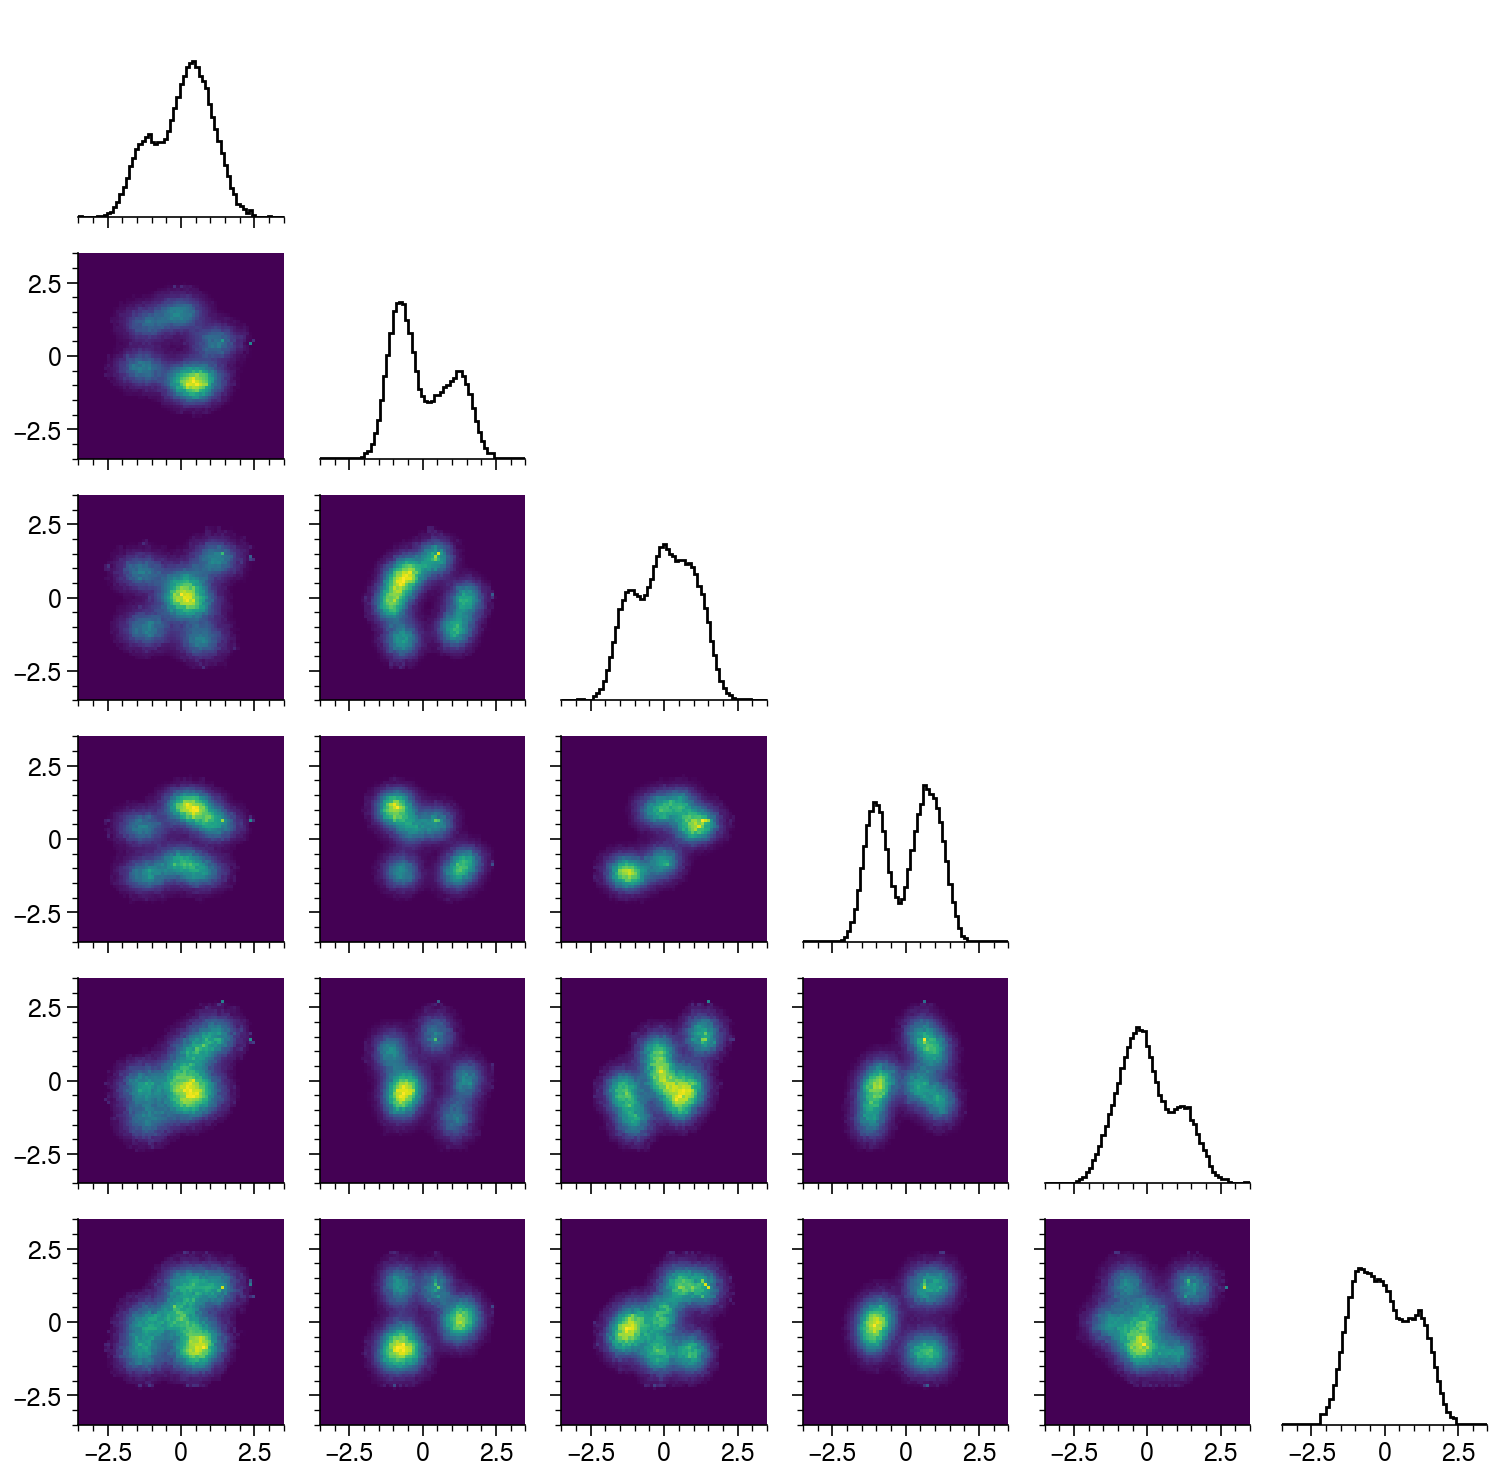

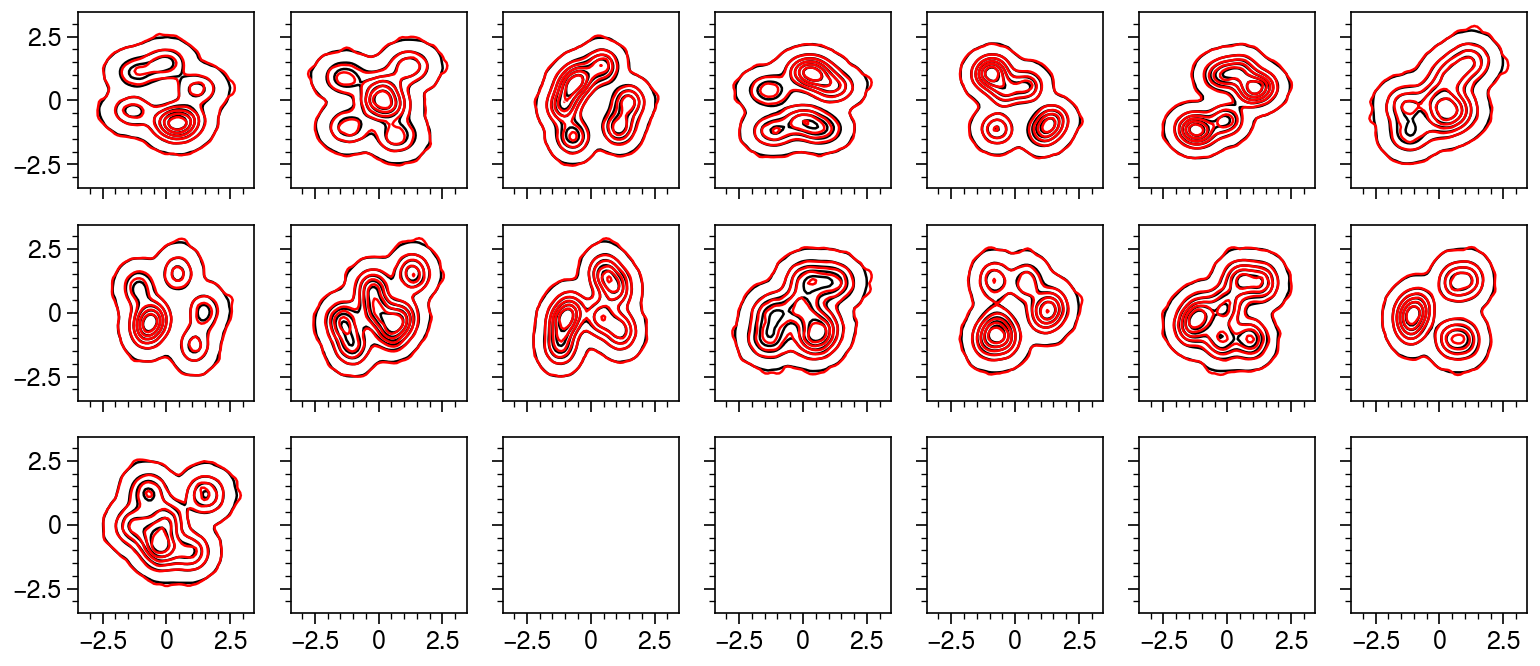

None


In [13]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=None,
    notebook=True,
)
trainer.train(
    epochs=3,
    learning_rate=0.80,
)

## Final check

In [14]:
X = model.sample(100_000)

  0%|                                                                                                                                                                 | 0/599 [00:00<?, ?it/s]

 11%|████████████████▏                                                                                                                                      | 64/599 [00:00<00:00, 637.79it/s]

 22%|████████████████████████████████▎                                                                                                                     | 129/599 [00:00<00:00, 641.41it/s]

 32%|████████████████████████████████████████████████▌                                                                                                     | 194/599 [00:00<00:00, 640.26it/s]

 43%|████████████████████████████████████████████████████████████████▊                                                                                     | 259/599 [00:00<00:00, 640.40it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                    | 324/599 [00:00<00:00, 640.57it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 390/599 [00:00<00:00, 645.57it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 455/599 [00:00<00:00, 646.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 520/599 [00:00<00:00, 624.27it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 584/599 [00:00<00:00, 627.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 599/599 [00:00<00:00, 635.26it/s]